In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
import os
import time
from tqdm.notebook import tqdm
from collections import defaultdict, Counter

# For reproducibility
import random
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score,accuracy_score
)

# Check for GPU availability
print("Checking GPU availability...")
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"Found {len(gpu_devices)} GPU(s):")
    for device in gpu_devices:
        print(f" - {device}")

    # Configure TensorFlow to use the GPU
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print("GPU memory growth enabled")
else:
    print("No GPU found. Using CPU instead.")

# TensorFlow version info
print(f"TensorFlow version: {tf.__version__}")

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Create directories for saving results
os.makedirs("results", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# Global parameters
NUM_RUNS = 5  # Number of runs with different initializations for robustness evaluation
EPOCHS = 100
BATCH_SIZE = 64  # Increased batch size for GPU
EARLY_STOPPING_PATIENCE = 100

# Function to download and load the data
def load_data(verbose=True):
    """
    Download and load the earthquake dataset.

    Parameters:
    -----------
    verbose : bool, default=True
        Whether to print dataset statistics

    Returns:
    --------
    tuple
        (X_train, y_train, X_test, y_test) where X is the data and y is the label
    """
    # URLs for the dataset
    train_url = "https://maxime-devanne.com/datasets/Earthquakes/Earthquakes_TRAIN.tsv"
    test_url = "https://maxime-devanne.com/datasets/Earthquakes/Earthquakes_TEST.tsv"

    # Download data
    train_response = requests.get(train_url)
    test_response = requests.get(test_url)

    # Load data
    train_data = pd.read_csv(StringIO(train_response.text), sep='\t', header=None)
    test_data = pd.read_csv(StringIO(test_response.text), sep='\t', header=None)

    # Extract labels and features
    X_train = train_data.iloc[:, 1:].values
    y_train = train_data.iloc[:, 0].values
    X_test = test_data.iloc[:, 1:].values
    y_test = test_data.iloc[:, 0].values

    if verbose:
        print("Dataset Statistics:")
        print(f"Training data shape: {X_train.shape}")
        print(f"Test data shape: {X_test.shape}")

        # Check for class imbalance
        unique_labels, counts = np.unique(y_train, return_counts=True)
        print("\nClass distribution in training set:")
        for label, count in zip(unique_labels, counts):
            print(f"Class {label}: {count} samples ({count/len(y_train)*100:.2f}%)")

        unique_labels_test, counts_test = np.unique(y_test, return_counts=True)
        print("\nClass distribution in test set:")
        for label, count in zip(unique_labels_test, counts_test):
            print(f"Class {label}: {count} samples ({count/len(y_test)*100:.2f}%)")

        # Check for missing values
        print(f"\nMissing values in training set: {np.isnan(X_train).sum()}")
        print(f"Missing values in test set: {np.isnan(X_test).sum()}")

        # Basic statistics
        print("\nTraining data statistics:")
        print(f"Mean: {np.mean(X_train):.4f}")
        print(f"Std: {np.std(X_train):.4f}")
        print(f"Min: {np.min(X_train):.4f}")
        print(f"Max: {np.max(X_train):.4f}")

    return X_train, y_train, X_test, y_test

# Load the data
X_train, y_train, X_test, y_test = load_data()

# Preprocess the data for different models
def preprocess_data(X_train, y_train, X_test, y_test, verbose=True):
    """
    Preprocess the data by scaling features and encoding labels.
    """
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # One-hot encode labels for training
    y_train_categorical = to_categorical(y_train_encoded)
    y_test_categorical = to_categorical(y_test_encoded)

    # Calculate class weights to handle class imbalance
    class_counts = np.bincount(y_train_encoded)
    total_samples = len(y_train_encoded)
    class_weights = {i: total_samples / (len(class_counts) * count)
                      for i, count in enumerate(class_counts)}

    # Reshape for CNN and RNN (samples, timesteps, features)
    X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0],
                                             X_train_scaled.shape[1], 1)
    X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],
                                           X_test_scaled.shape[1], 1)

    if verbose:
        print("Preprocessed data shapes:")
        print(f"X_train_scaled: {X_train_scaled.shape}")
        print(f"X_train_reshaped: {X_train_reshaped.shape}")
        print(f"y_train_categorical: {y_train_categorical.shape}")
        print(f"Class weights: {class_weights}")

    return (X_train_scaled, X_test_scaled, y_train_categorical, y_test_categorical,
            X_train_reshaped, X_test_reshaped, class_weights,
            label_encoder, y_train_encoded, y_test_encoded)

# Preprocess the data
(X_train_scaled, X_test_scaled, y_train_categorical, y_test_categorical,
 X_train_reshaped, X_test_reshaped, class_weights,
 label_encoder, y_train_encoded, y_test_encoded) = preprocess_data(X_train, y_train, X_test, y_test)

# Define models
def create_mlp_model(input_shape, dropout_rate=0.3, l2_reg=0.001):
    """Create a Multi-Layer Perceptron (MLP) model using the Functional API."""
    inputs = layers.Input(shape=input_shape)

    # Flatten the input
    x = layers.Flatten()(inputs)

    # Dense layers with regularization
    x = layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer
    outputs = layers.Dense(2, activation='softmax')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs, name="MLP")

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_cnn_model(input_shape, dropout_rate=0.3, l2_reg=0.001):
    """Create a Convolutional Neural Network (CNN) model using the Functional API."""
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers
    x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(filters=256, kernel_size=3, padding='same', activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Global pooling to reduce dimensionality
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer
    outputs = layers.Dense(2, activation='softmax')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs, name="CNN")

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_rnn_model(input_shape, dropout_rate=0.3, l2_reg=0.001):
    """Create a Recurrent Neural Network (RNN) model using the Functional API."""
    inputs = layers.Input(shape=input_shape)

    # Bidirectional LSTM layers
    x = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True,
                   kernel_regularizer=regularizers.l2(l2_reg))
    )(inputs)
    x = layers.BatchNormalization()(x)

    x = layers.Bidirectional(
        layers.LSTM(64, return_sequences=False,
                   kernel_regularizer=regularizers.l2(l2_reg))
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Dense layers
    x = layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer
    outputs = layers.Dense(2, activation='softmax')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs, name="RNN")

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Function to train and evaluate a model with detailed metrics
def train_and_evaluate_model(model_creator, X_train, y_train, X_test, y_test,
                            class_weights, model_name, run_number=0):
    """Train and evaluate a model with detailed metrics."""
    # Calculate model input shape
    input_shape = X_train.shape[1:]

    # Create model
    model = model_creator(input_shape)

    # Define callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        verbose=0
    )

    # Add TensorBoard callback for monitoring
    tensorboard_callback = callbacks.TensorBoard(
        log_dir=f"./logs/{model_name}_{run_number}",
        histogram_freq=1,
        profile_batch='500,520'
    )

    # Add model checkpoint callback
    checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=f"results/{model_name}_{run_number}/model_checkpoint.h5",
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=0
    )

    # Measure training time
    start_time = time.time()

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        class_weight=class_weights,
        callbacks=[early_stopping, tensorboard_callback, checkpoint_callback],
        verbose=1
    )

    training_time = time.time() - start_time

    # Measure inference time
    start_time = time.time()
    y_pred_proba = model.predict(X_test, verbose=0)
    inference_time = time.time() - start_time

    # Convert probabilities to class predictions
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate evaluation metrics
    accuracy = np.mean(y_pred == y_true)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # For the positive class (major event)
    positive_class = 1  # Assuming 1 is the major event class
    y_pred_proba_pos = y_pred_proba[:, positive_class]

    # Calculate ROC AUC
    try:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba_pos, pos_label=positive_class)
        roc_auc = auc(fpr, tpr)
    except:
        roc_auc = 0

    # Calculate PR AUC
    try:
        precision_curve, recall_curve, _ = precision_recall_curve(
            y_true, y_pred_proba_pos, pos_label=positive_class)
        pr_auc = average_precision_score(
            y_true, y_pred_proba_pos, pos_label=positive_class)
    except:
        pr_auc = 0

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a dictionary with evaluation metrics
    evaluation_metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm,
        'training_time': training_time,
        'inference_time': inference_time,
        'num_params': model.count_params(),
        'run_number': run_number
    }

    # Print a summary of results
    print(f"\n{model_name} - Run {run_number} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Training Time: {training_time:.2f}s")
    print(f"Inference Time: {inference_time:.4f}s")
    print(f"Parameters: {model.count_params():,}")

    # Save model and metrics
    model_dir = f"results/{model_name}_{run_number}"
    os.makedirs(model_dir, exist_ok=True)

    # Save evaluation metrics
    np.save(f"{model_dir}/evaluation_metrics.npy", evaluation_metrics)

    return model, history, evaluation_metrics, training_time, inference_time

# Function to monitor GPU usage
def print_gpu_utilization():
    """Print GPU memory usage statistics."""
    try:
        # Only works if nvidia-smi is available
        import subprocess
        result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv,noheader,nounits'],
                              stdout=subprocess.PIPE,
                              check=True)
        gpu_memory = result.stdout.decode('utf-8').strip().split('\n')
        for i, mem in enumerate(gpu_memory):
            used, total = mem.split(',')
            print(f"GPU {i}: {used.strip()} MB / {total.strip()} MB")
    except:
        print("Could not check GPU memory (nvidia-smi not available or failed)")

# Dictionary to store results for all models and runs
results = {
    'MLP': [],
    'CNN': [],
    'RNN': []
}

# Dictionary mapping model names to creation functions
model_creators = {
    'MLP': create_mlp_model,
    'CNN': create_cnn_model,
    'RNN': create_rnn_model
}

# Dictionary mapping model names to corresponding data
model_data = {
    'MLP': (X_train_scaled, y_train_categorical, X_test_scaled, y_test_categorical),
    'CNN': (X_train_reshaped, y_train_categorical, X_test_reshaped, y_test_categorical),
    'RNN': (X_train_reshaped, y_train_categorical, X_test_reshaped, y_test_categorical)
}

# Train each model multiple times with different initializations
for model_name, model_creator in model_creators.items():
    print(f"\nTraining {model_name} model with {NUM_RUNS} different initializations...")

    X_train_model, y_train_model, X_test_model, y_test_model = model_data[model_name]

    # Print GPU status before training
    print("GPU status before training:")
    print_gpu_utilization()

    for run in range(NUM_RUNS):
        # Set random seeds for this run
        np.random.seed(SEED + 2*run)
        tf.random.set_seed(SEED + 2*run)
        random.seed(SEED + 2*run)

        # Train and evaluate model
        _, _, evaluation_metrics, _, _ = train_and_evaluate_model(
            model_creator,
            X_train_model, y_train_model,
            X_test_model, y_test_model,
            class_weights,
            model_name,
            run
        )

        # Save results
        results[model_name].append(evaluation_metrics)

    # Print GPU status after training
    print("GPU status after training:")
    print_gpu_utilization()

Checking GPU availability...
Found 1 GPU(s):
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU memory growth enabled
TensorFlow version: 2.18.0
Dataset Statistics:
Training data shape: (322, 512)
Test data shape: (139, 512)

Class distribution in training set:
Class 0: 264 samples (81.99%)
Class 1: 58 samples (18.01%)

Class distribution in test set:
Class 0: 104 samples (74.82%)
Class 1: 35 samples (25.18%)

Missing values in training set: 0
Missing values in test set: 0

Training data statistics:
Mean: -0.0000
Std: 0.9990
Min: -0.8858
Max: 7.8634
Preprocessed data shapes:
X_train_scaled: (322, 512)
X_train_reshaped: (322, 512, 1)
y_train_categorical: (322, 2)
Class weights: {0: np.float64(0.6098484848484849), 1: np.float64(2.7758620689655173)}

Training MLP model with 5 different initializations...
GPU status before training:
GPU 0: 2 MB / 15360 MB
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.4398 - loss: 2.0236

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 848ms/step - accuracy: 0.4372 - loss: 2.0306 - val_accuracy: 0.5385 - val_loss: 1.3528
Epoch 2/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6250 - loss: 1.3033

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.6043 - loss: 1.4399 - val_accuracy: 0.6000 - val_loss: 1.3189
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6385 - loss: 1.1831 - val_accuracy: 0.6000 - val_loss: 1.3203
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6489 - loss: 1.1325 - val_accuracy: 0.6000 - val_loss: 1.3229
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7209 - loss: 1.0839 - val_accuracy: 0.6154 - val_loss: 1.3300
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7501 - loss: 0.9634 - val_accuracy: 0.6154 - val_loss: 1.3387
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7292 - loss: 0.9800 - val_accuracy: 0.6000 - val_loss: 1.3507
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8245 - loss: 0.9074 - val_accuracy: 0.6154 - val_loss: 1.3596
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8229 - loss: 0.9014 - val_accuracy: 0.6154 - val_loss: 1.3625
Epoc

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4690 - loss: 1.8164 - val_accuracy: 0.6308 - val_loss: 1.2216
Epoch 2/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6094 - loss: 1.2221

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5754 - loss: 1.3678 - val_accuracy: 0.7231 - val_loss: 1.1546
Epoch 3/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5781 - loss: 1.2882

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6170 - loss: 1.1963 - val_accuracy: 0.7692 - val_loss: 1.1154
Epoch 4/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6250 - loss: 1.1921

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6753 - loss: 1.0984 - val_accuracy: 0.7846 - val_loss: 1.0981
Epoch 5/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7344 - loss: 1.0264

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7618 - loss: 1.0192 - val_accuracy: 0.7692 - val_loss: 1.0969
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7670 - loss: 0.9427 - val_accuracy: 0.7538 - val_loss: 1.0985
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8073 - loss: 0.9045 - val_accuracy: 0.7538 - val_loss: 1.1050
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8333 - loss: 0.8633 - val_accuracy: 0.7692 - val_loss: 1.1127
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8286 - loss: 0.8302 - val_accuracy: 0.7538 - val_loss: 1.1292
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8463 - loss: 0.8187 - val_accuracy: 0.7538 - val_loss: 1.1480
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8884 - loss: 0.7777 - val_accuracy: 0.7538 - val_loss: 1.1617
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9042 - loss: 0.7599 - val_accuracy: 0.7385 - val_loss: 1.1727
E

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 917ms/step - accuracy: 0.5158 - loss: 1.8350 - val_accuracy: 0.5846 - val_loss: 1.2424
Epoch 2/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.6094 - loss: 1.4806

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6058 - loss: 1.3749 - val_accuracy: 0.6769 - val_loss: 1.2015
Epoch 3/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6875 - loss: 1.2434

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6654 - loss: 1.1790 - val_accuracy: 0.6615 - val_loss: 1.1763
Epoch 4/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - accuracy: 0.7344 - loss: 1.0935

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7176 - loss: 1.1043 - val_accuracy: 0.6769 - val_loss: 1.1608
Epoch 5/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7812 - loss: 1.0256

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7662 - loss: 1.0317 - val_accuracy: 0.6769 - val_loss: 1.1554
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7907 - loss: 0.9700 - val_accuracy: 0.6769 - val_loss: 1.1576
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8013 - loss: 0.9141 - val_accuracy: 0.6615 - val_loss: 1.1631
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8052 - loss: 0.9074 - val_accuracy: 0.6615 - val_loss: 1.1766
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8442 - loss: 0.8520 - val_accuracy: 0.6615 - val_loss: 1.1972
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8398 - loss: 0.8374 - val_accuracy: 0.6308 - val_loss: 1.2206
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8661 - loss: 0.8028 - val_accuracy: 0.6462 - val_loss: 1.2458
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8888 - loss: 0.7581 - val_accuracy: 0.6462 - val_loss: 1.2695
E


MLP - Run 2 Results:
Accuracy: 0.6978
F1 Score: 0.6879
Training Time: 44.15s
Inference Time: 0.7512s
Parameters: 174,402
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.4783 - loss: 1.7545

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 732ms/step - accuracy: 0.4777 - loss: 1.7614 - val_accuracy: 0.8615 - val_loss: 1.0564
Epoch 2/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6406 - loss: 1.2244

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6253 - loss: 1.2790 - val_accuracy: 0.8769 - val_loss: 1.0424
Epoch 3/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6719 - loss: 1.1182

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6288 - loss: 1.2664 - val_accuracy: 0.8769 - val_loss: 1.0368
Epoch 4/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5625 - loss: 1.2086

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6313 - loss: 1.1653 - val_accuracy: 0.8615 - val_loss: 1.0349
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6968 - loss: 1.0754 - val_accuracy: 0.8462 - val_loss: 1.0354
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7235 - loss: 1.0191 - val_accuracy: 0.8615 - val_loss: 1.0374
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7364 - loss: 0.9670 - val_accuracy: 0.8615 - val_loss: 1.0427
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8071 - loss: 0.9170 - val_accuracy: 0.8462 - val_loss: 1.0471
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7813 - loss: 0.8932 - val_accuracy: 0.8308 - val_loss: 1.0532
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7960 - loss: 0.8627 - val_accuracy: 0.8308 - val_loss: 1.0597
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8231 - loss: 0.8374 - val_accuracy: 0.8000 - val_loss: 1.0655
Ep

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 940ms/step - accuracy: 0.4432 - loss: 1.8180 - val_accuracy: 0.8615 - val_loss: 1.0319
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5971 - loss: 1.2623 - val_accuracy: 0.8615 - val_loss: 1.0456
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6448 - loss: 1.1874 - val_accuracy: 0.8308 - val_loss: 1.0659
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6491 - loss: 1.1489 - val_accuracy: 0.8000 - val_loss: 1.0920
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6697 - loss: 1.0638 - val_accuracy: 0.7538 - val_loss: 1.1262
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6645 - loss: 1.0542 - val_accuracy: 0.7077 - val_loss: 1.1613
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7113 - loss: 0.9853 - val_accuracy: 0.6308 - val_loss: 1.1957
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6901 - loss: 1.0021 - val_accuracy: 0.6154 - val_loss: 1.2276
Epo

5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4937 - loss: 1.6361 - val_accuracy: 0.1385 - val_loss: 1.2077
Epoch 2/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5785 - loss: 1.3374

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5802 - loss: 1.3323 - val_accuracy: 0.8615 - val_loss: 1.1920
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5487 - loss: 1.2971 - val_accuracy: 0.8000 - val_loss: 1.1964
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5472 - loss: 1.2180 - val_accuracy: 0.8154 - val_loss: 1.1942
Epoch 5/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6536 - loss: 1.0702 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.6524 - loss: 1.0730 - val_accuracy: 0.8615 - val_loss: 1.1841
Epoch 6/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6393 - loss: 1.0456 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6454 - loss: 1.0469 - val_accuracy: 0.8615 - val_loss: 1.1809
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.6456 - loss: 1.0353 - val_accuracy: 0.8462 - val_loss: 1.1867
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7416 - loss: 0.9118 - val_accuracy: 0.6769 - val_loss: 1.1866
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.7668 - loss: 0.8598 - val_accuracy: 0.5385 - val_loss: 1.1830
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7147 - loss: 0.9292 - val_accuracy: 0.4923 - val_loss: 1.1819
Epoch 11/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7728 - loss: 0.9257

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7811 - loss: 0.9147 - val_accuracy: 0.7692 - val_loss: 1.1730
Epoch 12/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8320 - loss: 0.8084

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8413 - loss: 0.7955 - val_accuracy: 0.8615 - val_loss: 1.1534
Epoch 13/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8031 - loss: 0.7718 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8155 - loss: 0.7696 - val_accuracy: 0.8615 - val_loss: 1.1358
Epoch 14/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8939 - loss: 0.7492

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8929 - loss: 0.7456 - val_accuracy: 0.8615 - val_loss: 1.1161
Epoch 15/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8828 - loss: 0.7042

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.8882 - loss: 0.7014 - val_accuracy: 0.8615 - val_loss: 1.1071
Epoch 16/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8727 - loss: 0.6637

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8775 - loss: 0.6643 - val_accuracy: 0.8615 - val_loss: 1.1031
Epoch 17/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9196 - loss: 0.6473

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9192 - loss: 0.6430 - val_accuracy: 0.8615 - val_loss: 1.0951
Epoch 18/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8945 - loss: 0.7104

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9037 - loss: 0.6955 - val_accuracy: 0.8615 - val_loss: 1.0929
Epoch 19/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8877 - loss: 0.6770 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8927 - loss: 0.6678 - val_accuracy: 0.8615 - val_loss: 1.0769
Epoch 20/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9316 - loss: 0.6335 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9389 - loss: 0.6264 - val_accuracy: 0.8615 - val_loss: 1.0569
Epoch 21/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8906 - loss: 0.7395 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.8960 - loss: 0.7320 - val_accuracy: 0.8615 - val_loss: 1.0226
Epoch 22/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9264 - loss: 0.6226 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9276 - loss: 0.6198 - val_accuracy: 0.8615 - val_loss: 0.9740
Epoch 23/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9167 - loss: 0.6915

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9237 - loss: 0.6836 - val_accuracy: 0.8615 - val_loss: 0.9408
Epoch 24/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9202 - loss: 0.6196 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9274 - loss: 0.6115 - val_accuracy: 0.8615 - val_loss: 0.9217
Epoch 25/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9525 - loss: 0.5981 - val_accuracy: 0.8615 - val_loss: 0.9311
Epoch 26/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9478 - loss: 0.5956 - val_accuracy: 0.8615 - val_loss: 0.9391
Epoch 27/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9588 - loss: 0.5730 - val_accuracy: 0.8615 - val_loss: 0.9387
Epoch 28/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9443 - loss: 0.5889

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9486 - loss: 0.5847 - val_accuracy: 0.8615 - val_loss: 0.9089
Epoch 29/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9648 - loss: 0.5922 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9688 - loss: 0.5872 - val_accuracy: 0.8615 - val_loss: 0.8906
Epoch 30/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9401 - loss: 0.5866

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9445 - loss: 0.5808 - val_accuracy: 0.8615 - val_loss: 0.8736
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9573 - loss: 0.5797 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9592 - loss: 0.5778 - val_accuracy: 0.8615 - val_loss: 0.8687
Epoch 32/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9848 - loss: 0.5441 - val_accuracy: 0.8615 - val_loss: 0.8717
Epoch 33/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9824 - loss: 0.5534 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9831 - loss: 0.5499 - val_accuracy: 0.8615 - val_loss: 0.8656
Epoch 34/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9368 - loss: 0.5647 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9449 - loss: 0.5577 - val_accuracy: 0.8615 - val_loss: 0.8533
Epoch 35/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9653 - loss: 0.5449 - val_accuracy: 0.8615 - val_loss: 0.8552
Epoch 36/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9521 - loss: 0.5413

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9564 - loss: 0.5387 - val_accuracy: 0.8615 - val_loss: 0.8486
Epoch 37/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9795 - loss: 0.5165 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9824 - loss: 0.5125 - val_accuracy: 0.8615 - val_loss: 0.8446
Epoch 38/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9649 - loss: 0.5129 - val_accuracy: 0.8615 - val_loss: 0.8457
Epoch 39/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9919 - loss: 0.4872

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.9933 - loss: 0.4862 - val_accuracy: 0.8615 - val_loss: 0.8442
Epoch 40/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9931 - loss: 0.5069 - val_accuracy: 0.8615 - val_loss: 0.8459
Epoch 41/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9959 - loss: 0.4959 - val_accuracy: 0.8615 - val_loss: 0.8523
Epoch 42/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9902 - loss: 0.4898 - val_accuracy: 0.8615 - val_loss: 0.8630
Epoch 43/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9905 - loss: 0.4860 - val_accuracy: 0.8615 - val_loss: 0.8751
Epoch 44/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9972 - loss: 0.4813 - val_accuracy: 0.8615 - val_loss: 0.8620
Epoch 45/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9876 - loss: 0.4767 - val_accuracy: 0.8615 - val_loss: 0.8521
Epoch 46/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.4657 - val_accuracy: 0.8615 - val_loss: 0

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.4667 - val_accuracy: 0.8615 - val_loss: 0.8433
Epoch 48/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9905 - loss: 0.4747 - val_accuracy: 0.8615 - val_loss: 0.8955
Epoch 49/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9866 - loss: 0.4706 - val_accuracy: 0.8615 - val_loss: 0.8769
Epoch 50/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9885 - loss: 0.4656 - val_accuracy: 0.8615 - val_loss: 0.8885
Epoch 51/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9981 - loss: 0.4704 - val_accuracy: 0.8615 - val_loss: 0.8638
Epoch 52/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9861 - loss: 0.4751 - val_accuracy: 0.8615 - val_loss: 0.9366
Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9913 - loss: 0.4658 - val_accuracy: 0.8615 - val_loss: 0.9947
Epoch 54/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9892 - loss: 0.4679 - val_accuracy: 0.8615 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CNN - Run 0 Results:
Accuracy: 0.7482
F1 Score: 0.6404
Training Time: 69.28s
Inference Time: 1.3179s
Parameters: 183,874
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.5108 - loss: 1.6550

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5145 - loss: 1.6444 - val_accuracy: 0.8615 - val_loss: 1.1914
Epoch 2/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5625 - loss: 1.3033

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5631 - loss: 1.2907 - val_accuracy: 0.8615 - val_loss: 1.1759
Epoch 3/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5605 - loss: 1.2401

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5695 - loss: 1.2207 - val_accuracy: 0.8615 - val_loss: 1.1502
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6497 - loss: 1.1200

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6504 - loss: 1.1185 - val_accuracy: 0.8615 - val_loss: 1.1147
Epoch 5/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6152 - loss: 1.1337

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6268 - loss: 1.1154 - val_accuracy: 0.8615 - val_loss: 1.0819
Epoch 6/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7025 - loss: 1.0537 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.7031 - loss: 1.0651 - val_accuracy: 0.8615 - val_loss: 1.0450
Epoch 7/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7734 - loss: 0.9148

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7763 - loss: 0.9116 - val_accuracy: 0.8615 - val_loss: 1.0123
Epoch 8/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7477 - loss: 0.9067

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7553 - loss: 0.8939 - val_accuracy: 0.8615 - val_loss: 0.9808
Epoch 9/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7549 - loss: 0.8581

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.7575 - loss: 0.8580 - val_accuracy: 0.8615 - val_loss: 0.9452
Epoch 10/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7760 - loss: 0.8050

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7755 - loss: 0.8146 - val_accuracy: 0.8615 - val_loss: 0.9185
Epoch 11/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8359 - loss: 0.7536

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.8413 - loss: 0.7590 - val_accuracy: 0.8615 - val_loss: 0.9046
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8600 - loss: 0.7338 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8639 - loss: 0.7314 - val_accuracy: 0.8615 - val_loss: 0.8964
Epoch 13/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8132 - loss: 0.7323

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8184 - loss: 0.7326 - val_accuracy: 0.8615 - val_loss: 0.8904
Epoch 14/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9059 - loss: 0.6770

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9049 - loss: 0.6846 - val_accuracy: 0.8615 - val_loss: 0.8864
Epoch 15/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8910 - loss: 0.6669 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8949 - loss: 0.6639 - val_accuracy: 0.8615 - val_loss: 0.8812
Epoch 16/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8932 - loss: 0.6871

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8925 - loss: 0.6830 - val_accuracy: 0.8615 - val_loss: 0.8790
Epoch 17/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9226 - loss: 0.6447 - val_accuracy: 0.8615 - val_loss: 0.8904
Epoch 18/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9326 - loss: 0.6017 - val_accuracy: 0.8615 - val_loss: 0.8970
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9467 - loss: 0.5970 - val_accuracy: 0.8615 - val_loss: 0.9059
Epoch 20/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9690 - loss: 0.5631 - val_accuracy: 0.8615 - val_loss: 0.9096
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9573 - loss: 0.5639 - val_accuracy: 0.8615 - val_loss: 0.9173
Epoch 22/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9731 - loss: 0.5545 - val_accuracy: 0.8615 - val_loss: 0.9187
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9707 - loss: 0.5682 - val_accuracy: 0.8615 - val_loss: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CNN - Run 1 Results:
Accuracy: 0.7482
F1 Score: 0.6404
Training Time: 68.01s
Inference Time: 1.3169s
Parameters: 183,874
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.4783 - loss: 1.6629

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4803 - loss: 1.6516 - val_accuracy: 0.3692 - val_loss: 1.2059
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5805 - loss: 1.3354

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5785 - loss: 1.3353 - val_accuracy: 0.8615 - val_loss: 1.1930
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5390 - loss: 1.4406 - val_accuracy: 0.7846 - val_loss: 1.1934
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6246 - loss: 1.2504 - val_accuracy: 0.1692 - val_loss: 1.2153
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6556 - loss: 1.0882 - val_accuracy: 0.1385 - val_loss: 1.2273
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6845 - loss: 1.0792 - val_accuracy: 0.2000 - val_loss: 1.2275
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.7137 - loss: 1.0563 - val_accuracy: 0.2769 - val_loss: 1.2226
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.7503 - loss: 0.9472 - val_accuracy: 0.2923 - val_loss: 1.2161
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7588 - loss: 0.9071 - val_accuracy: 0.2923 - val_loss: 1.2138

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9905 - loss: 0.4729 - val_accuracy: 0.6615 - val_loss: 1.0722
Epoch 62/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9873 - loss: 0.4784 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9876 - loss: 0.4786 - val_accuracy: 0.8308 - val_loss: 0.7879
Epoch 63/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9952 - loss: 0.4638 - val_accuracy: 0.8615 - val_loss: 0.8855
Epoch 64/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9939 - loss: 0.4552 - val_accuracy: 0.8615 - val_loss: 0.9874
Epoch 65/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9961 - loss: 0.4525 - val_accuracy: 0.8615 - val_loss: 1.0127
Epoch 66/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9933 - loss: 0.4519 - val_accuracy: 0.8615 - val_loss: 1.0021
Epoch 67/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9961 - loss: 0.4475 - val_accuracy: 0.8615 - val_loss: 0.8770
Epoch 68/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9961 - loss: 0.4500 - val_accuracy: 0.8615 - val_loss: 0.8193
Epoch 69/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9981 - loss: 0.4461 - val_accuracy: 0.8615 - val_loss: 1

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5457 - loss: 1.5857 - val_accuracy: 0.1385 - val_loss: 1.2185
Epoch 2/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5495 - loss: 1.3425

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5518 - loss: 1.3487 - val_accuracy: 0.8615 - val_loss: 1.1901
Epoch 3/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5495 - loss: 1.2740 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.5492 - loss: 1.2953 - val_accuracy: 0.8615 - val_loss: 1.1470
Epoch 4/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5628 - loss: 1.2308 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5646 - loss: 1.2391 - val_accuracy: 0.8615 - val_loss: 1.1043
Epoch 5/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6426 - loss: 1.0523 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.6398 - loss: 1.0583 - val_accuracy: 0.8615 - val_loss: 1.0757
Epoch 6/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6406 - loss: 1.0855 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6541 - loss: 1.0755 - val_accuracy: 0.8615 - val_loss: 1.0450
Epoch 7/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7227 - loss: 0.9366 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7165 - loss: 0.9546 - val_accuracy: 0.8615 - val_loss: 1.0192
Epoch 8/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7057 - loss: 0.9414 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.7130 - loss: 0.9340 - val_accuracy: 0.8615 - val_loss: 0.9958
Epoch 9/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7425 - loss: 0.8926

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.7414 - loss: 0.8979 - val_accuracy: 0.8615 - val_loss: 0.9787
Epoch 10/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7751 - loss: 0.8789 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.7761 - loss: 0.8943 - val_accuracy: 0.8615 - val_loss: 0.9617
Epoch 11/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8011 - loss: 0.8221 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.8039 - loss: 0.8223 - val_accuracy: 0.8615 - val_loss: 0.9448
Epoch 12/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7965 - loss: 0.8132 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.8008 - loss: 0.8085 - val_accuracy: 0.8615 - val_loss: 0.9335
Epoch 13/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8034 - loss: 0.7909 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8093 - loss: 0.7903 - val_accuracy: 0.8615 - val_loss: 0.9214
Epoch 14/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8545 - loss: 0.7814

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.8524 - loss: 0.7786 - val_accuracy: 0.8615 - val_loss: 0.9084
Epoch 15/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8682 - loss: 0.7506

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.8719 - loss: 0.7565 - val_accuracy: 0.8615 - val_loss: 0.8985
Epoch 16/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8607 - loss: 0.6847

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.8734 - loss: 0.6814 - val_accuracy: 0.8615 - val_loss: 0.8894
Epoch 17/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8805 - loss: 0.6676 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.8853 - loss: 0.6677 - val_accuracy: 0.8615 - val_loss: 0.8825
Epoch 18/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9030 - loss: 0.6494

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9094 - loss: 0.6463 - val_accuracy: 0.8615 - val_loss: 0.8783
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9053 - loss: 0.6790 - val_accuracy: 0.8615 - val_loss: 0.8830
Epoch 20/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9244 - loss: 0.6225 - val_accuracy: 0.8615 - val_loss: 0.8883
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9287 - loss: 0.6055 - val_accuracy: 0.8615 - val_loss: 0.8943
Epoch 22/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9352 - loss: 0.6086 - val_accuracy: 0.8615 - val_loss: 0.9040
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9426 - loss: 0.5871 - val_accuracy: 0.8615 - val_loss: 0.9114
Epoch 24/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9454 - loss: 0.5898 - val_accuracy: 0.8615 - val_loss: 0.9194
Epoch 25/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9476 - loss: 0.5734 - val_accuracy: 0.8615 - val_loss: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CNN - Run 3 Results:
Accuracy: 0.7482
F1 Score: 0.6404
Training Time: 67.38s
Inference Time: 2.6414s
Parameters: 183,874
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.5454 - loss: 1.5025

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5466 - loss: 1.4969 - val_accuracy: 0.4462 - val_loss: 1.2042
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.5442 - loss: 1.4054 - val_accuracy: 0.1385 - val_loss: 1.2247
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5982 - loss: 1.1689 - val_accuracy: 0.2308 - val_loss: 1.2148
Epoch 4/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5436 - loss: 1.3194 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.5505 - loss: 1.2932 - val_accuracy: 0.6462 - val_loss: 1.1917
Epoch 5/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5687 - loss: 1.1373

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5711 - loss: 1.1420 - val_accuracy: 0.4000 - val_loss: 1.1913
Epoch 6/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6302 - loss: 1.0929 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.6419 - loss: 1.0763 - val_accuracy: 0.4154 - val_loss: 1.1891
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.6638 - loss: 1.0075 - val_accuracy: 0.3846 - val_loss: 1.1934
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6023 - loss: 1.0590 - val_accuracy: 0.4000 - val_loss: 1.1911
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6094 - loss: 0.9675 - val_accuracy: 0.4000 - val_loss: 1.1929
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.6424 - loss: 0.9408 - val_accuracy: 0.3538 - val_loss: 1.2028
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.6881 - loss: 0.9401 - val_accuracy: 0.3385 - val_loss: 1.2075
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7178 - loss: 0.8748 - val_accuracy: 0.2769 - val_loss: 1.2307
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6905 - loss: 0.9312 - val_accuracy: 0.2615 - val_loss: 1.2630

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8155 - loss: 0.7133 - val_accuracy: 0.4615 - val_loss: 1.1541
Epoch 20/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7829 - loss: 0.7622

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7943 - loss: 0.7494 - val_accuracy: 0.4769 - val_loss: 1.1436
Epoch 21/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8363 - loss: 0.7019 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.8403 - loss: 0.6977 - val_accuracy: 0.4923 - val_loss: 1.1349
Epoch 22/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8477 - loss: 0.7406

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8621 - loss: 0.7203 - val_accuracy: 0.8154 - val_loss: 1.0986
Epoch 23/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8477 - loss: 0.6840

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8595 - loss: 0.6731 - val_accuracy: 0.8462 - val_loss: 1.0731
Epoch 24/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8827 - loss: 0.6495 - val_accuracy: 0.6462 - val_loss: 1.1101
Epoch 25/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8258 - loss: 0.6800 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.8359 - loss: 0.6754 - val_accuracy: 0.8308 - val_loss: 1.0452
Epoch 26/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8258 - loss: 0.7230

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8359 - loss: 0.7067 - val_accuracy: 0.8615 - val_loss: 0.9979
Epoch 27/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9136 - loss: 0.6271

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9137 - loss: 0.6264 - val_accuracy: 0.8615 - val_loss: 0.9584
Epoch 28/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9248 - loss: 0.6269 - val_accuracy: 0.8308 - val_loss: 1.0323
Epoch 29/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8894 - loss: 0.6056 - val_accuracy: 0.6923 - val_loss: 1.0517
Epoch 30/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8819 - loss: 0.6579 - val_accuracy: 0.8462 - val_loss: 1.0062
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9289 - loss: 0.5981 - val_accuracy: 0.8462 - val_loss: 0.9677
Epoch 32/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9120 - loss: 0.5857 - val_accuracy: 0.7846 - val_loss: 1.0193
Epoch 33/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8899 - loss: 0.6232 - val_accuracy: 0.5538 - val_loss: 1.1062
Epoch 34/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9150 - loss: 0.5855 - val_accuracy: 0.3846 - val_loss: 1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



CNN - Run 4 Results:
Accuracy: 0.7482
F1 Score: 0.6404
Training Time: 67.83s
Inference Time: 1.3189s
Parameters: 183,874
GPU status after training:
GPU 0: 392 MB / 15360 MB

Training RNN model with 5 different initializations...
GPU status before training:
GPU 0: 392 MB / 15360 MB
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5087 - loss: 1.4475 

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - accuracy: 0.5102 - loss: 1.4461 - val_accuracy: 0.7385 - val_loss: 1.1122
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5717 - loss: 1.3084 

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.5717 - loss: 1.3146 - val_accuracy: 0.7846 - val_loss: 1.1047
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5810 - loss: 1.2260

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.5828 - loss: 1.2332 - val_accuracy: 0.8308 - val_loss: 1.0976
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6211 - loss: 1.2370

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.6194 - loss: 1.2309 - val_accuracy: 0.8769 - val_loss: 1.0883
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6159 - loss: 1.1217

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.6157 - loss: 1.1256 - val_accuracy: 0.8615 - val_loss: 1.0762
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6284 - loss: 1.2341

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.6281 - loss: 1.2345 - val_accuracy: 0.8615 - val_loss: 1.0651
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5904 - loss: 1.2380

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.5945 - loss: 1.2408 - val_accuracy: 0.8615 - val_loss: 1.0586
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5977 - loss: 1.0940

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.6005 - loss: 1.0941 - val_accuracy: 0.8615 - val_loss: 1.0495
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6836 - loss: 0.9277

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.6896 - loss: 0.9253 - val_accuracy: 0.8615 - val_loss: 1.0373
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6836 - loss: 0.9875

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.6851 - loss: 0.9950 - val_accuracy: 0.8615 - val_loss: 1.0269
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5940 - loss: 1.0921

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.5982 - loss: 1.0931 - val_accuracy: 0.8615 - val_loss: 1.0181
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6752 - loss: 0.9422

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.6794 - loss: 0.9390 - val_accuracy: 0.8615 - val_loss: 1.0062
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7216 - loss: 0.9123

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.7245 - loss: 0.9194 - val_accuracy: 0.8615 - val_loss: 0.9984
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7153 - loss: 0.9659

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.7148 - loss: 0.9756 - val_accuracy: 0.8615 - val_loss: 0.9900
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6883 - loss: 0.9507

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.6903 - loss: 0.9491 - val_accuracy: 0.8615 - val_loss: 0.9825
Epoch 16/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6893 - loss: 0.9311

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.6879 - loss: 0.9368 - val_accuracy: 0.8615 - val_loss: 0.9723
Epoch 17/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7101 - loss: 0.8906

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.7124 - loss: 0.8928 - val_accuracy: 0.8615 - val_loss: 0.9612
Epoch 18/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6815 - loss: 0.9442

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.6840 - loss: 0.9436 - val_accuracy: 0.8615 - val_loss: 0.9507
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6482 - loss: 0.9562

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.6517 - loss: 0.9543 - val_accuracy: 0.8615 - val_loss: 0.9391
Epoch 20/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7148 - loss: 0.9023

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7182 - loss: 0.9026 - val_accuracy: 0.8615 - val_loss: 0.9258
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7554 - loss: 0.8139

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.7527 - loss: 0.8152 - val_accuracy: 0.8615 - val_loss: 0.9167
Epoch 22/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7731 - loss: 0.8277

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.7739 - loss: 0.8271 - val_accuracy: 0.8615 - val_loss: 0.9113
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7658 - loss: 0.8557

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.7653 - loss: 0.8560 - val_accuracy: 0.8615 - val_loss: 0.9046
Epoch 24/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7210 - loss: 0.8506

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.7234 - loss: 0.8478 - val_accuracy: 0.8615 - val_loss: 0.8971
Epoch 25/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7466 - loss: 0.8222

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.7466 - loss: 0.8231 - val_accuracy: 0.8615 - val_loss: 0.8901
Epoch 26/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7585 - loss: 0.8178

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7553 - loss: 0.8246 - val_accuracy: 0.8615 - val_loss: 0.8865
Epoch 27/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7694 - loss: 0.7826

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.7735 - loss: 0.7804 - val_accuracy: 0.8615 - val_loss: 0.8810
Epoch 28/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7528 - loss: 0.8047

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.7544 - loss: 0.8019 - val_accuracy: 0.8615 - val_loss: 0.8733
Epoch 29/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7517 - loss: 0.8263

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7549 - loss: 0.8212 - val_accuracy: 0.8615 - val_loss: 0.8662
Epoch 30/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7564 - loss: 0.8485

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7594 - loss: 0.8428 - val_accuracy: 0.8615 - val_loss: 0.8591
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7736 - loss: 0.7989

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.7737 - loss: 0.8009 - val_accuracy: 0.8615 - val_loss: 0.8478
Epoch 32/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8225 - loss: 0.7510

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8242 - loss: 0.7522 - val_accuracy: 0.8615 - val_loss: 0.8334
Epoch 33/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8053 - loss: 0.6997

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.8093 - loss: 0.6989 - val_accuracy: 0.8769 - val_loss: 0.8259
Epoch 34/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7767 - loss: 0.7665

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.7783 - loss: 0.7640 - val_accuracy: 0.8769 - val_loss: 0.8250
Epoch 35/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7778 - loss: 0.7581

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.7791 - loss: 0.7606 - val_accuracy: 0.8769 - val_loss: 0.8208
Epoch 36/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7866 - loss: 0.7653

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.7910 - loss: 0.7612 - val_accuracy: 0.8615 - val_loss: 0.8157
Epoch 37/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8116 - loss: 0.7358

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.8132 - loss: 0.7332 - val_accuracy: 0.8615 - val_loss: 0.8124
Epoch 38/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7965 - loss: 0.7535

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7948 - loss: 0.7575 - val_accuracy: 0.8615 - val_loss: 0.8013
Epoch 39/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8121 - loss: 0.6517

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8155 - loss: 0.6522 - val_accuracy: 0.8769 - val_loss: 0.7923
Epoch 40/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8034 - loss: 0.7197 - val_accuracy: 0.8615 - val_loss: 0.8020
Epoch 41/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.7993 - loss: 0.7053 - val_accuracy: 0.8462 - val_loss: 0.8072
Epoch 42/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8110 - loss: 0.6418 - val_accuracy: 0.8462 - val_loss: 0.8033
Epoch 43/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8266 - loss: 0.6864 - val_accuracy: 0.8462 - val_loss: 0.7979
Epoch 44/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8423 - loss: 0.6281

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8452 - loss: 0.6308 - val_accuracy: 0.8462 - val_loss: 0.7854
Epoch 45/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8397 - loss: 0.6414

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8437 - loss: 0.6393 - val_accuracy: 0.8615 - val_loss: 0.7742
Epoch 46/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8204 - loss: 0.6492

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.8218 - loss: 0.6507 - val_accuracy: 0.8769 - val_loss: 0.7678
Epoch 47/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8444 - loss: 0.6094

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.8476 - loss: 0.6075 - val_accuracy: 0.8769 - val_loss: 0.7551
Epoch 48/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8355 - loss: 0.5991

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.8364 - loss: 0.6013 - val_accuracy: 0.8769 - val_loss: 0.7538
Epoch 49/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.8513 - loss: 0.6225 - val_accuracy: 0.8462 - val_loss: 0.7564
Epoch 50/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8901 - loss: 0.5737 - val_accuracy: 0.8462 - val_loss: 0.7559
Epoch 51/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8803 - loss: 0.5892

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8821 - loss: 0.5872 - val_accuracy: 0.8769 - val_loss: 0.7452
Epoch 52/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8439 - loss: 0.5762

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.8485 - loss: 0.5729 - val_accuracy: 0.8615 - val_loss: 0.7410
Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8787 - loss: 0.5391

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.8808 - loss: 0.5393 - val_accuracy: 0.8615 - val_loss: 0.7381
Epoch 54/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8850 - loss: 0.5369

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.8873 - loss: 0.5351 - val_accuracy: 0.8615 - val_loss: 0.7321
Epoch 55/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8903 - loss: 0.5144 - val_accuracy: 0.8615 - val_loss: 0.7340
Epoch 56/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.8830 - loss: 0.5316 - val_accuracy: 0.8462 - val_loss: 0.7492
Epoch 57/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.9057 - loss: 0.5218 - val_accuracy: 0.8154 - val_loss: 0.7689
Epoch 58/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.9098 - loss: 0.5249 - val_accuracy: 0.8154 - val_loss: 0.7632
Epoch 59/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.8879 - loss: 0.5217 - val_accuracy: 0.8154 - val_loss: 0.7550
Epoch 60/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8760 - loss: 0.5131 - val_accuracy: 0.8154 - val_loss: 0.7667
Epoch 61/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9036 - loss: 0.5220 - val_accuracy: 0.8154 - val_lo

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - accuracy: 0.5566 - loss: 1.4334 - val_accuracy: 0.8462 - val_loss: 1.1078
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5857 - loss: 1.4523

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.5873 - loss: 1.4508 - val_accuracy: 0.8615 - val_loss: 1.0872
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6112 - loss: 1.2055

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.6105 - loss: 1.2080 - val_accuracy: 0.8615 - val_loss: 1.0660
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6170 - loss: 1.2790

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.6153 - loss: 1.2699 - val_accuracy: 0.8615 - val_loss: 1.0436
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6201 - loss: 1.2741

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.6224 - loss: 1.2670 - val_accuracy: 0.8615 - val_loss: 1.0241
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6654 - loss: 1.0641

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.6660 - loss: 1.0648 - val_accuracy: 0.8615 - val_loss: 1.0055
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6498 - loss: 1.0773

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.6472 - loss: 1.0810 - val_accuracy: 0.8615 - val_loss: 0.9889
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6300 - loss: 1.1046

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.6307 - loss: 1.1001 - val_accuracy: 0.8615 - val_loss: 0.9723
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6789 - loss: 1.0169

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.6812 - loss: 1.0095 - val_accuracy: 0.8615 - val_loss: 0.9589
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6794 - loss: 0.9882

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.6784 - loss: 0.9938 - val_accuracy: 0.8615 - val_loss: 0.9459
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7002 - loss: 1.0725

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.7003 - loss: 1.0657 - val_accuracy: 0.8615 - val_loss: 0.9346
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6690 - loss: 0.8916

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.6736 - loss: 0.8891 - val_accuracy: 0.8615 - val_loss: 0.9208
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7185 - loss: 0.9337

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.7180 - loss: 0.9333 - val_accuracy: 0.8615 - val_loss: 0.9077
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6513 - loss: 1.0095

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.6556 - loss: 1.0022 - val_accuracy: 0.8615 - val_loss: 0.8975
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6903 - loss: 0.9900

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.6907 - loss: 0.9945 - val_accuracy: 0.8615 - val_loss: 0.8891
Epoch 16/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7044 - loss: 0.9691

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.7076 - loss: 0.9651 - val_accuracy: 0.8615 - val_loss: 0.8789
Epoch 17/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7096 - loss: 0.9183

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.7119 - loss: 0.9183 - val_accuracy: 0.8615 - val_loss: 0.8697
Epoch 18/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7304 - loss: 0.9156

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.7306 - loss: 0.9141 - val_accuracy: 0.8615 - val_loss: 0.8621
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7481 - loss: 0.9680

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.7486 - loss: 0.9650 - val_accuracy: 0.8615 - val_loss: 0.8610
Epoch 20/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7601 - loss: 0.8783

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7573 - loss: 0.8860 - val_accuracy: 0.8615 - val_loss: 0.8601
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7075 - loss: 0.9303

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.7089 - loss: 0.9373 - val_accuracy: 0.8615 - val_loss: 0.8566
Epoch 22/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7237 - loss: 0.9368

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.7243 - loss: 0.9358 - val_accuracy: 0.8615 - val_loss: 0.8551
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7439 - loss: 0.9156

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.7477 - loss: 0.9127 - val_accuracy: 0.8615 - val_loss: 0.8547
Epoch 24/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7263 - loss: 0.8984

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.7258 - loss: 0.8984 - val_accuracy: 0.8615 - val_loss: 0.8493
Epoch 25/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7944 - loss: 0.8588

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7976 - loss: 0.8507 - val_accuracy: 0.8615 - val_loss: 0.8399
Epoch 26/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8080 - loss: 0.7475

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.8043 - loss: 0.7488 - val_accuracy: 0.8615 - val_loss: 0.8339
Epoch 27/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7819 - loss: 0.7097

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.7865 - loss: 0.7098 - val_accuracy: 0.8615 - val_loss: 0.8311
Epoch 28/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7736 - loss: 0.8743

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7718 - loss: 0.8692 - val_accuracy: 0.8615 - val_loss: 0.8279
Epoch 29/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7580 - loss: 0.7911

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.7562 - loss: 0.7945 - val_accuracy: 0.8615 - val_loss: 0.8196
Epoch 30/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7533 - loss: 0.8331

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.7542 - loss: 0.8300 - val_accuracy: 0.8615 - val_loss: 0.8168
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8189 - loss: 0.6842

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.8199 - loss: 0.6850 - val_accuracy: 0.8769 - val_loss: 0.8099
Epoch 32/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7668 - loss: 0.8070

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7707 - loss: 0.8076 - val_accuracy: 0.8769 - val_loss: 0.8076
Epoch 33/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8522 - loss: 0.7275

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.8515 - loss: 0.7249 - val_accuracy: 0.8769 - val_loss: 0.7952
Epoch 34/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.8331 - loss: 0.7815 - val_accuracy: 0.8769 - val_loss: 0.8002
Epoch 35/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.8123 - loss: 0.7464 - val_accuracy: 0.8769 - val_loss: 0.7983
Epoch 36/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7918 - loss: 0.7562

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7902 - loss: 0.7585 - val_accuracy: 0.8769 - val_loss: 0.7866
Epoch 37/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8168 - loss: 0.7062

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.8182 - loss: 0.7060 - val_accuracy: 0.8769 - val_loss: 0.7782
Epoch 38/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7949 - loss: 0.7097

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.7960 - loss: 0.7128 - val_accuracy: 0.8769 - val_loss: 0.7712
Epoch 39/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8418 - loss: 0.6560

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.8377 - loss: 0.6596 - val_accuracy: 0.8769 - val_loss: 0.7564
Epoch 40/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8220 - loss: 0.6528

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.8212 - loss: 0.6551 - val_accuracy: 0.8769 - val_loss: 0.7561
Epoch 41/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8322 - loss: 0.7173 - val_accuracy: 0.8769 - val_loss: 0.7617
Epoch 42/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8522 - loss: 0.6643 - val_accuracy: 0.8769 - val_loss: 0.7689
Epoch 43/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.8489 - loss: 0.6740 - val_accuracy: 0.8769 - val_loss: 0.7564
Epoch 44/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8439 - loss: 0.6271

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.8452 - loss: 0.6261 - val_accuracy: 0.9077 - val_loss: 0.7440
Epoch 45/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.8377 - loss: 0.6737 - val_accuracy: 0.8769 - val_loss: 0.7596
Epoch 46/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.8823 - loss: 0.6208 - val_accuracy: 0.8154 - val_loss: 0.7858
Epoch 47/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8773 - loss: 0.5855 - val_accuracy: 0.8000 - val_loss: 0.7986
Epoch 48/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8940 - loss: 0.6007 - val_accuracy: 0.8462 - val_loss: 0.7806
Epoch 49/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8537 - loss: 0.6329 - val_accuracy: 0.8462 - val_loss: 0.7789
Epoch 50/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8673 - loss: 0.6282

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.8680 - loss: 0.6275 - val_accuracy: 0.8615 - val_loss: 0.7390
Epoch 51/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8793 - loss: 0.5642 - val_accuracy: 0.8615 - val_loss: 0.7722
Epoch 52/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.8563 - loss: 0.5936 - val_accuracy: 0.6308 - val_loss: 0.9026
Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.8823 - loss: 0.5986 - val_accuracy: 0.7538 - val_loss: 0.8508
Epoch 54/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.8637 - loss: 0.5801 - val_accuracy: 0.6923 - val_loss: 0.8724
Epoch 55/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9135 - loss: 0.5115 - val_accuracy: 0.6769 - val_loss: 0.8609
Epoch 56/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.9068 - loss: 0.5129 - val_accuracy: 0.7846 - val_loss: 0.7862
Epoch 57/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.8981 - loss: 0.5381 - val_accuracy: 0.7231 - val_lo

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 341ms/step - accuracy: 0.5117 - loss: 1.6142 - val_accuracy: 0.1385 - val_loss: 1.1411
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.5379 - loss: 1.2693 - val_accuracy: 0.1385 - val_loss: 1.1516
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.6322 - loss: 1.1336 - val_accuracy: 0.1385 - val_loss: 1.1617
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.5698 - loss: 1.2144 - val_accuracy: 0.1385 - val_loss: 1.1661
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.6348 - loss: 1.1196 - val_accuracy: 0.1385 - val_loss: 1.1691
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.5884 - loss: 1.1403 - val_accuracy: 0.1385 - val_loss: 1.1692
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.6086 - loss: 1.1635 - val_accuracy: 0.1385 - val_loss: 1.1733
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.6175 - loss: 1.0918 - val_accuracy: 0.1538 - val_loss: 1.1

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7779 - loss: 0.7752 - val_accuracy: 0.2154 - val_loss: 1.1371
Epoch 22/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7507 - loss: 0.8182

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7469 - loss: 0.8189 - val_accuracy: 0.2462 - val_loss: 1.1301
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7835 - loss: 0.7878

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.7775 - loss: 0.7879 - val_accuracy: 0.2462 - val_loss: 1.1235
Epoch 24/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7643 - loss: 0.8079

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.7633 - loss: 0.8057 - val_accuracy: 0.2462 - val_loss: 1.1217
Epoch 25/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7944 - loss: 0.8002

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7917 - loss: 0.7979 - val_accuracy: 0.2462 - val_loss: 1.1172
Epoch 26/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8038 - loss: 0.7615

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.7989 - loss: 0.7656 - val_accuracy: 0.2769 - val_loss: 1.1069
Epoch 27/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7632 - loss: 0.8104

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.7631 - loss: 0.8058 - val_accuracy: 0.2923 - val_loss: 1.1012
Epoch 28/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7767 - loss: 0.7613

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.7763 - loss: 0.7593 - val_accuracy: 0.3077 - val_loss: 1.0936
Epoch 29/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7918 - loss: 0.7480

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.7883 - loss: 0.7521 - val_accuracy: 0.3385 - val_loss: 1.0789
Epoch 30/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8205 - loss: 0.7879

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.8160 - loss: 0.7881 - val_accuracy: 0.3385 - val_loss: 1.0690
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7762 - loss: 0.7397

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.7753 - loss: 0.7359 - val_accuracy: 0.3692 - val_loss: 1.0667
Epoch 32/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8496 - loss: 0.6794

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.8494 - loss: 0.6785 - val_accuracy: 0.4000 - val_loss: 1.0618
Epoch 33/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7898 - loss: 0.6980

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.7885 - loss: 0.6979 - val_accuracy: 0.4000 - val_loss: 1.0511
Epoch 34/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8283 - loss: 0.6901

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.8258 - loss: 0.6887 - val_accuracy: 0.4462 - val_loss: 1.0380
Epoch 35/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7939 - loss: 0.7254

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7939 - loss: 0.7228 - val_accuracy: 0.5385 - val_loss: 1.0161
Epoch 36/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8356 - loss: 0.7386

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8331 - loss: 0.7338 - val_accuracy: 0.6615 - val_loss: 0.9920
Epoch 37/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8127 - loss: 0.6668

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.8102 - loss: 0.6636 - val_accuracy: 0.6615 - val_loss: 0.9773
Epoch 38/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7944 - loss: 0.7137

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.7963 - loss: 0.7090 - val_accuracy: 0.7077 - val_loss: 0.9579
Epoch 39/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8397 - loss: 0.6388

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8398 - loss: 0.6350 - val_accuracy: 0.7077 - val_loss: 0.9395
Epoch 40/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8361 - loss: 0.6293

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.8336 - loss: 0.6301 - val_accuracy: 0.7231 - val_loss: 0.9320
Epoch 41/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8772 - loss: 0.6107

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.8724 - loss: 0.6089 - val_accuracy: 0.7077 - val_loss: 0.9177
Epoch 42/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8715 - loss: 0.5869

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.8689 - loss: 0.5861 - val_accuracy: 0.7231 - val_loss: 0.8998
Epoch 43/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8491 - loss: 0.6028

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8470 - loss: 0.6049 - val_accuracy: 0.7077 - val_loss: 0.8938
Epoch 44/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.8492 - loss: 0.5907 - val_accuracy: 0.7077 - val_loss: 0.9003
Epoch 45/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.8960 - loss: 0.5706 - val_accuracy: 0.7385 - val_loss: 0.8998
Epoch 46/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8793 - loss: 0.5635

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8799 - loss: 0.5619 - val_accuracy: 0.7077 - val_loss: 0.8927
Epoch 47/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8761 - loss: 0.5506

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.8741 - loss: 0.5513 - val_accuracy: 0.7231 - val_loss: 0.8763
Epoch 48/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9037 - loss: 0.5330

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9003 - loss: 0.5335 - val_accuracy: 0.7385 - val_loss: 0.8570
Epoch 49/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9136 - loss: 0.4991

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.9137 - loss: 0.5000 - val_accuracy: 0.7538 - val_loss: 0.8399
Epoch 50/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8886 - loss: 0.5460

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8858 - loss: 0.5477 - val_accuracy: 0.7538 - val_loss: 0.8293
Epoch 51/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.9361 - loss: 0.5031 - val_accuracy: 0.7385 - val_loss: 0.8363
Epoch 52/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.8890 - loss: 0.5261 - val_accuracy: 0.7385 - val_loss: 0.8497
Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9126 - loss: 0.4933

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.9109 - loss: 0.4920 - val_accuracy: 0.7692 - val_loss: 0.8285
Epoch 54/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9058 - loss: 0.5218

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.9053 - loss: 0.5183 - val_accuracy: 0.7692 - val_loss: 0.7926
Epoch 55/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9355 - loss: 0.4762

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.9358 - loss: 0.4740 - val_accuracy: 0.8154 - val_loss: 0.7614
Epoch 56/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.9216 - loss: 0.4788 - val_accuracy: 0.8000 - val_loss: 0.7614
Epoch 57/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9089 - loss: 0.4685

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.9072 - loss: 0.4697 - val_accuracy: 0.8154 - val_loss: 0.7612
Epoch 58/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9417 - loss: 0.4148

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.9404 - loss: 0.4148 - val_accuracy: 0.8000 - val_loss: 0.7431
Epoch 59/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9428 - loss: 0.4116

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.9419 - loss: 0.4125 - val_accuracy: 0.8154 - val_loss: 0.7284
Epoch 60/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9719 - loss: 0.4024

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.9695 - loss: 0.4037 - val_accuracy: 0.8154 - val_loss: 0.7144
Epoch 61/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9584 - loss: 0.3887

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.9562 - loss: 0.3903 - val_accuracy: 0.8308 - val_loss: 0.6972
Epoch 62/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9551 - loss: 0.4173 - val_accuracy: 0.7692 - val_loss: 0.7173
Epoch 63/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9530 - loss: 0.4063 - val_accuracy: 0.7846 - val_loss: 0.7004
Epoch 64/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9672 - loss: 0.4018

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.9668 - loss: 0.3996 - val_accuracy: 0.8000 - val_loss: 0.6941
Epoch 65/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9597 - loss: 0.3921 - val_accuracy: 0.8000 - val_loss: 0.7040
Epoch 66/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.9640 - loss: 0.3792 - val_accuracy: 0.8000 - val_loss: 0.7188
Epoch 67/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.9508 - loss: 0.4063 - val_accuracy: 0.8000 - val_loss: 0.7251
Epoch 68/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.9389 - loss: 0.4142 - val_accuracy: 0.8154 - val_loss: 0.7441
Epoch 69/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9526 - loss: 0.4002

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.9528 - loss: 0.3984 - val_accuracy: 0.8154 - val_loss: 0.6732
Epoch 70/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9506 - loss: 0.3843

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.9491 - loss: 0.3854 - val_accuracy: 0.8615 - val_loss: 0.6470
Epoch 71/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9666 - loss: 0.3771 - val_accuracy: 0.8308 - val_loss: 0.6797
Epoch 72/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.9575 - loss: 0.3436 - val_accuracy: 0.8000 - val_loss: 0.7220
Epoch 73/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9562 - loss: 0.3522 - val_accuracy: 0.8000 - val_loss: 0.7435
Epoch 74/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9629 - loss: 0.3317 - val_accuracy: 0.8308 - val_loss: 0.7681
Epoch 75/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.9658 - loss: 0.3517 - val_accuracy: 0.8154 - val_loss: 0.7598
Epoch 76/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.9449 - loss: 0.4030 - val_accuracy: 0.5692 - val_loss: 1.1003
Epoch 77/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.9135 - loss: 0.5176 - val_accuracy: 0.5692 - val_lo

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step - accuracy: 0.6036 - loss: 1.3289 - val_accuracy: 0.8154 - val_loss: 1.1057
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6112 - loss: 1.2916

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.6099 - loss: 1.2998 - val_accuracy: 0.8769 - val_loss: 1.0894
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5764 - loss: 1.1777

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.5795 - loss: 1.1806 - val_accuracy: 0.8769 - val_loss: 1.0683
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6112 - loss: 1.2405

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.6138 - loss: 1.2310 - val_accuracy: 0.8615 - val_loss: 1.0475
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6050 - loss: 1.1446

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.6073 - loss: 1.1471 - val_accuracy: 0.8615 - val_loss: 1.0229
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6435 - loss: 1.0644

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.6458 - loss: 1.0643 - val_accuracy: 0.8615 - val_loss: 1.0019
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6643 - loss: 1.0474

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.6639 - loss: 1.0483 - val_accuracy: 0.8615 - val_loss: 0.9819
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7132 - loss: 1.0085

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7150 - loss: 1.0083 - val_accuracy: 0.8615 - val_loss: 0.9627
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7112 - loss: 0.9992

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7100 - loss: 1.0033 - val_accuracy: 0.8615 - val_loss: 0.9464
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7039 - loss: 0.9742

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.7007 - loss: 0.9786 - val_accuracy: 0.8615 - val_loss: 0.9269
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7096 - loss: 0.9921

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7074 - loss: 0.9965 - val_accuracy: 0.8615 - val_loss: 0.9118
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6961 - loss: 0.9564

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.6942 - loss: 0.9596 - val_accuracy: 0.8615 - val_loss: 0.8982
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7143 - loss: 0.9443

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.7126 - loss: 0.9474 - val_accuracy: 0.8615 - val_loss: 0.8871
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7278 - loss: 0.8507

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.7278 - loss: 0.8541 - val_accuracy: 0.8615 - val_loss: 0.8762
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7544 - loss: 0.9369

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.7525 - loss: 0.9381 - val_accuracy: 0.8615 - val_loss: 0.8652
Epoch 16/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7887 - loss: 0.7951

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.7863 - loss: 0.7993 - val_accuracy: 0.8615 - val_loss: 0.8543
Epoch 17/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7835 - loss: 0.8917

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.7794 - loss: 0.9010 - val_accuracy: 0.8615 - val_loss: 0.8442
Epoch 18/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7013 - loss: 0.8936

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7024 - loss: 0.8953 - val_accuracy: 0.8615 - val_loss: 0.8323
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7491 - loss: 0.8606

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.7501 - loss: 0.8650 - val_accuracy: 0.8615 - val_loss: 0.8214
Epoch 20/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7538 - loss: 0.8217

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.7527 - loss: 0.8304 - val_accuracy: 0.8615 - val_loss: 0.8123
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8017 - loss: 0.7490

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7985 - loss: 0.7553 - val_accuracy: 0.8615 - val_loss: 0.8050
Epoch 22/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7413 - loss: 0.8019

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7436 - loss: 0.8037 - val_accuracy: 0.8615 - val_loss: 0.7991
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7575 - loss: 0.7683

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.7570 - loss: 0.7690 - val_accuracy: 0.8615 - val_loss: 0.7908
Epoch 24/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7585 - loss: 0.8194

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.7599 - loss: 0.8212 - val_accuracy: 0.8615 - val_loss: 0.7829
Epoch 25/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7632 - loss: 0.8776

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7644 - loss: 0.8829 - val_accuracy: 0.8615 - val_loss: 0.7751
Epoch 26/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8111 - loss: 0.7676

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.8108 - loss: 0.7684 - val_accuracy: 0.8615 - val_loss: 0.7678
Epoch 27/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7809 - loss: 0.7893

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.7792 - loss: 0.7962 - val_accuracy: 0.8615 - val_loss: 0.7626
Epoch 28/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8293 - loss: 0.7356

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.8279 - loss: 0.7387 - val_accuracy: 0.8615 - val_loss: 0.7564
Epoch 29/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7965 - loss: 0.7166

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.7948 - loss: 0.7210 - val_accuracy: 0.8615 - val_loss: 0.7515
Epoch 30/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8147 - loss: 0.6988

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.8132 - loss: 0.7013 - val_accuracy: 0.8615 - val_loss: 0.7470
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8069 - loss: 0.7453

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8099 - loss: 0.7444 - val_accuracy: 0.8615 - val_loss: 0.7429
Epoch 32/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8074 - loss: 0.7542

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.8078 - loss: 0.7583 - val_accuracy: 0.8615 - val_loss: 0.7420
Epoch 33/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7491 - loss: 0.8556

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.7520 - loss: 0.8495 - val_accuracy: 0.8615 - val_loss: 0.7346
Epoch 34/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8298 - loss: 0.6669

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.8309 - loss: 0.6676 - val_accuracy: 0.8615 - val_loss: 0.7326
Epoch 35/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8267 - loss: 0.6698

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.8258 - loss: 0.6757 - val_accuracy: 0.8615 - val_loss: 0.7319
Epoch 36/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8751 - loss: 0.6008

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.8726 - loss: 0.6034 - val_accuracy: 0.8615 - val_loss: 0.7272
Epoch 37/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8163 - loss: 0.6790

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.8177 - loss: 0.6757 - val_accuracy: 0.8615 - val_loss: 0.7178
Epoch 38/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8387 - loss: 0.6896

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.8357 - loss: 0.6932 - val_accuracy: 0.8615 - val_loss: 0.7112
Epoch 39/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8121 - loss: 0.6878

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.8117 - loss: 0.6870 - val_accuracy: 0.8615 - val_loss: 0.7070
Epoch 40/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8558 - loss: 0.6320

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.8559 - loss: 0.6328 - val_accuracy: 0.8769 - val_loss: 0.7035
Epoch 41/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8465 - loss: 0.6545

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.8468 - loss: 0.6543 - val_accuracy: 0.8769 - val_loss: 0.7006
Epoch 42/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8595 - loss: 0.5885

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.8576 - loss: 0.5941 - val_accuracy: 0.8769 - val_loss: 0.6960
Epoch 43/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8319 - loss: 0.6764

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8327 - loss: 0.6841 - val_accuracy: 0.8769 - val_loss: 0.6858
Epoch 44/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8808 - loss: 0.5688

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.8767 - loss: 0.5773 - val_accuracy: 0.8769 - val_loss: 0.6822
Epoch 45/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8543 - loss: 0.6214

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.8539 - loss: 0.6217 - val_accuracy: 0.8769 - val_loss: 0.6816
Epoch 46/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8954 - loss: 0.5633

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.8947 - loss: 0.5667 - val_accuracy: 0.8923 - val_loss: 0.6799
Epoch 47/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8959 - loss: 0.5862

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.8945 - loss: 0.5893 - val_accuracy: 0.8923 - val_loss: 0.6788
Epoch 48/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8626 - loss: 0.6260

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.8622 - loss: 0.6274 - val_accuracy: 0.8923 - val_loss: 0.6723
Epoch 49/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8642 - loss: 0.5846

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.8660 - loss: 0.5858 - val_accuracy: 0.8923 - val_loss: 0.6666
Epoch 50/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8815 - loss: 0.5337 - val_accuracy: 0.8923 - val_loss: 0.6682
Epoch 51/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8824 - loss: 0.5454

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.8838 - loss: 0.5443 - val_accuracy: 0.8923 - val_loss: 0.6643
Epoch 52/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8975 - loss: 0.5561

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8996 - loss: 0.5543 - val_accuracy: 0.8923 - val_loss: 0.6619
Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9162 - loss: 0.5234

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.9166 - loss: 0.5232 - val_accuracy: 0.8923 - val_loss: 0.6585
Epoch 54/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8845 - loss: 0.5381

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.8862 - loss: 0.5377 - val_accuracy: 0.9077 - val_loss: 0.6568
Epoch 55/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8819 - loss: 0.5391

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.8821 - loss: 0.5419 - val_accuracy: 0.8923 - val_loss: 0.6478
Epoch 56/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9081 - loss: 0.5282 - val_accuracy: 0.8923 - val_loss: 0.6552
Epoch 57/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8990 - loss: 0.5967 - val_accuracy: 0.8462 - val_loss: 0.6560
Epoch 58/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.8910 - loss: 0.5176 - val_accuracy: 0.8154 - val_loss: 0.6824
Epoch 59/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.9263 - loss: 0.5059 - val_accuracy: 0.8308 - val_loss: 0.6849
Epoch 60/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.9181 - loss: 0.4950 - val_accuracy: 0.8308 - val_loss: 0.6740
Epoch 61/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.9218 - loss: 0.4980 - val_accuracy: 0.8615 - val_loss: 0.6685
Epoch 62/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9233 - loss: 0.4817 - val_accuracy: 0.8154 - val_lo

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - accuracy: 0.4824 - loss: 1.7443 - val_accuracy: 0.4000 - val_loss: 1.1264
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.5021 - loss: 1.4370 - val_accuracy: 0.2308 - val_loss: 1.1436
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.6027 - loss: 1.1819 - val_accuracy: 0.1385 - val_loss: 1.1642
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.6021 - loss: 1.1936 - val_accuracy: 0.1385 - val_loss: 1.1900
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.5457 - loss: 1.1302 - val_accuracy: 0.1385 - val_loss: 1.2167
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.5741 - loss: 1.1240 - val_accuracy: 0.1385 - val_loss: 1.2422
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.5982 - loss: 1.1267 - val_accuracy: 0.1385 - val_loss: 1.2651
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.5678 - loss: 1.0792 - val_accuracy: 0.1385 - val_loss: 1.2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7063 - loss: 0.7266 - val_accuracy: 0.4615 - val_loss: 1.1189
Epoch 60/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.7028 - loss: 0.7232 - val_accuracy: 0.4769 - val_loss: 1.1221
Epoch 61/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.7293 - loss: 0.6918 - val_accuracy: 0.4923 - val_loss: 1.1392
Epoch 62/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6752 - loss: 0.7413

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.6807 - loss: 0.7335 - val_accuracy: 0.5231 - val_loss: 1.0826
Epoch 63/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6737 - loss: 0.7219

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.6814 - loss: 0.7155 - val_accuracy: 0.5231 - val_loss: 1.0435
Epoch 64/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.6829 - loss: 0.7016 - val_accuracy: 0.5538 - val_loss: 1.0811
Epoch 65/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7440 - loss: 0.6386 - val_accuracy: 0.5846 - val_loss: 1.0797
Epoch 66/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6617 - loss: 0.6755

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.6662 - loss: 0.6724 - val_accuracy: 0.5846 - val_loss: 1.0258
Epoch 67/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.7215 - loss: 0.6506 - val_accuracy: 0.5231 - val_loss: 1.0305
Epoch 68/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.7003 - loss: 0.6681 - val_accuracy: 0.6154 - val_loss: 1.0334
Epoch 69/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7491 - loss: 0.6318

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7501 - loss: 0.6309 - val_accuracy: 0.6462 - val_loss: 1.0004
Epoch 70/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7377 - loss: 0.6556

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7418 - loss: 0.6511 - val_accuracy: 0.6000 - val_loss: 0.9810
Epoch 71/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7538 - loss: 0.6355

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.7540 - loss: 0.6332 - val_accuracy: 0.6154 - val_loss: 0.9691
Epoch 72/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7632 - loss: 0.6207

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7663 - loss: 0.6166 - val_accuracy: 0.6769 - val_loss: 0.9278
Epoch 73/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.7286 - loss: 0.6297 - val_accuracy: 0.6154 - val_loss: 0.9478
Epoch 74/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7543 - loss: 0.6181

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.7577 - loss: 0.6138 - val_accuracy: 0.6615 - val_loss: 0.8704
Epoch 75/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7632 - loss: 0.6103

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.7676 - loss: 0.6034 - val_accuracy: 0.7077 - val_loss: 0.8590
Epoch 76/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7934 - loss: 0.5899

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.7960 - loss: 0.5861 - val_accuracy: 0.7077 - val_loss: 0.8531
Epoch 77/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7685 - loss: 0.5863 - val_accuracy: 0.6769 - val_loss: 0.9228
Epoch 78/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.7553 - loss: 0.5609 - val_accuracy: 0.6462 - val_loss: 0.9654
Epoch 79/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.8368 - loss: 0.5441 - val_accuracy: 0.7077 - val_loss: 0.9387
Epoch 80/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7915 - loss: 0.5636 - val_accuracy: 0.6615 - val_loss: 0.9946
Epoch 81/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.8129 - loss: 0.5296 - val_accuracy: 0.6769 - val_loss: 1.0514
Epoch 82/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8483 - loss: 0.5624 - val_accuracy: 0.7385 - val_loss: 0.9669
Epoch 83/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.8314 - loss: 0.5275 - val_accuracy: 0.7538 - val_lo

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.8398 - loss: 0.5087 - val_accuracy: 0.8308 - val_loss: 0.7198
Epoch 99/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8682 - loss: 0.4611 - val_accuracy: 0.8308 - val_loss: 0.9523
Epoch 100/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.8858 - loss: 0.4635 - val_accuracy: 0.8462 - val_loss: 1.0044

RNN - Run 4 Results:
Accuracy: 0.6906
F1 Score: 0.6891
Training Time: 109.14s
Inference Time: 1.2955s
Parameters: 142,274
GPU status after training:
GPU 0: 656 MB / 15360 MB


In [2]:
# GRU Model using Functional API
def create_gru_model(input_shape, dropout_rate=0.3, l2_reg=0.001):
    """Create a Gated Recurrent Unit (GRU) model using the Functional API."""
    inputs = layers.Input(shape=input_shape)

    # Bidirectional GRU layers
    x = layers.Bidirectional(
        layers.GRU(64, return_sequences=True,
                  kernel_regularizer=regularizers.l2(l2_reg))
    )(inputs)
    x = layers.BatchNormalization()(x)

    x = layers.Bidirectional(
        layers.GRU(64, return_sequences=False,
                  kernel_regularizer=regularizers.l2(l2_reg))
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Dense layers
    x = layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer
    outputs = layers.Dense(2, activation='softmax')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs, name="GRU")

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Import Random Forest
from sklearn.ensemble import RandomForestClassifier

# Function to train and evaluate a Random Forest model
def train_and_evaluate_random_forest(X_train, y_train, X_test, y_test, run_number=0):
    """Train and evaluate a Random Forest model with detailed metrics."""
    # Measure training time
    start_time = time.time()

    # Create and train the Random Forest model
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=True,
        class_weight='balanced',
        random_state=SEED + run_number,
        n_jobs=-1  # Use all available cores
    )

    model.fit(X_train, y_train)

    training_time = time.time() - start_time

    # Measure inference time
    start_time = time.time()
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    inference_time = time.time() - start_time

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # For the positive class (major event)
    positive_class = 1  # Assuming 1 is the major event class
    y_pred_proba_pos = y_pred_proba[:, positive_class]

    # Calculate ROC AUC
    try:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba_pos, pos_label=positive_class)
        roc_auc = auc(fpr, tpr)
    except:
        roc_auc = 0

    # Calculate PR AUC
    try:
        precision_curve, recall_curve, _ = precision_recall_curve(
            y_test, y_pred_proba_pos, pos_label=positive_class)
        pr_auc = average_precision_score(y_test, y_pred_proba_pos, pos_label=positive_class)
    except:
        pr_auc = 0

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a dictionary with evaluation metrics
    evaluation_metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm,
        'training_time': training_time,
        'inference_time': inference_time,
        'num_params': sum(tree.tree_.node_count for tree in model.estimators_),
        'run_number': run_number
    }

    # Print a summary of results
    print(f"\nRandom Forest - Run {run_number} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Training Time: {training_time:.2f}s")
    print(f"Inference Time: {inference_time:.4f}s")

    # Save metrics
    model_dir = f"results/RandomForest_{run_number}"
    os.makedirs(model_dir, exist_ok=True)

    # Save evaluation metrics
    np.save(f"{model_dir}/evaluation_metrics.npy", evaluation_metrics)

    # Save feature importances
    feature_importances = pd.DataFrame({
        'Feature': range(X_train.shape[1]),
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    feature_importances.to_csv(f"{model_dir}/feature_importances.csv", index=False)

    # Plot and save feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(30), model.feature_importances_[:30])  # Show top 30 features
    plt.title('Random Forest - Top 30 Feature Importances')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.savefig(f"{model_dir}/feature_importances.png", dpi=300, bbox_inches="tight")
    plt.close()

    return model, evaluation_metrics, training_time, inference_time

# Add GRU to the model creators and data dictionaries
model_creators['GRU'] = create_gru_model
model_data['GRU'] = (X_train_reshaped, y_train_categorical, X_test_reshaped, y_test_categorical)

# Train the GRU model
print(f"\nTraining GRU model with {NUM_RUNS} different initializations...")

# Print GPU status before training
print("GPU status before training GRU:")
print_gpu_utilization()

for run in range(NUM_RUNS):
    # Set random seeds for this run
    np.random.seed(SEED + run)
    tf.random.set_seed(SEED + run)
    random.seed(SEED + run)

    # Train and evaluate model
    _, _, evaluation_metrics, _, _ = train_and_evaluate_model(
        create_gru_model,
        X_train_reshaped, y_train_categorical,
        X_test_reshaped, y_test_categorical,
        class_weights,
        'GRU',
        run
    )

    # Save results
    if 'GRU' not in results:
        results['GRU'] = []
    results['GRU'].append(evaluation_metrics)

# Print GPU status after training
print("GPU status after training GRU:")
print_gpu_utilization()

# Train the Random Forest model
print(f"\nTraining Random Forest model with {NUM_RUNS} different initializations...")

rf_results = []
for run in range(NUM_RUNS):
    # Set random seed for this run
    np.random.seed(SEED + run)
    random.seed(SEED + run)

    # Train and evaluate model
    _, evaluation_metrics, _, _ = train_and_evaluate_random_forest(
        X_train_scaled, y_train_encoded,
        X_test_scaled, y_test_encoded,
        run
    )

    # Save results
    rf_results.append(evaluation_metrics)

# Add Random Forest results to the overall results
results['RandomForest'] = rf_results

# Compare all models
model_names = list(results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'pr_auc',
          'training_time', 'inference_time']

# Create a comparison table
comparison_data = []
for model_name in model_names:
    model_metrics = {}
    model_metrics['Model'] = model_name

    for metric in metrics:
        values = [result[metric] for result in results[model_name]]
        model_metrics[metric] = f"{np.mean(values):.4f} ± {np.std(values):.4f}"

    comparison_data.append(model_metrics)

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison (Mean ± Std across runs):")
print(comparison_df)


Training GRU model with 5 different initializations...
GPU status before training GRU:
GPU 0: 656 MB / 15360 MB
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5509 - loss: 1.2463

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - accuracy: 0.5486 - loss: 1.2617 - val_accuracy: 0.8154 - val_loss: 1.0692
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6305 - loss: 1.1374

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.6318 - loss: 1.1379 - val_accuracy: 0.8308 - val_loss: 1.0524
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6940 - loss: 1.1401

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.6944 - loss: 1.1398 - val_accuracy: 0.8615 - val_loss: 1.0377
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6034 - loss: 1.1450

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.6053 - loss: 1.1450 - val_accuracy: 0.8923 - val_loss: 1.0242
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6216 - loss: 1.0091

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.6237 - loss: 1.0150 - val_accuracy: 0.9077 - val_loss: 1.0057
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6300 - loss: 1.1005

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.6300 - loss: 1.1103 - val_accuracy: 0.8923 - val_loss: 0.9881
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6544 - loss: 1.1081

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.6569 - loss: 1.1118 - val_accuracy: 0.8923 - val_loss: 0.9777
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6159 - loss: 1.0836

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.6177 - loss: 1.0778 - val_accuracy: 0.9077 - val_loss: 0.9635
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6409 - loss: 1.0346

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.6430 - loss: 1.0322 - val_accuracy: 0.8923 - val_loss: 0.9477
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7059 - loss: 0.9205

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7083 - loss: 0.9215 - val_accuracy: 0.8923 - val_loss: 0.9341
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6341 - loss: 1.0415

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.6361 - loss: 1.0454 - val_accuracy: 0.8923 - val_loss: 0.9236
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7221 - loss: 0.8977

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.7198 - loss: 0.9037 - val_accuracy: 0.8923 - val_loss: 0.9147
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6622 - loss: 0.9847

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.6666 - loss: 0.9828 - val_accuracy: 0.8923 - val_loss: 0.9067
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6617 - loss: 0.9644

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.6649 - loss: 0.9621 - val_accuracy: 0.8923 - val_loss: 0.9031
Epoch 15/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6803 - loss: 0.9014

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.6883 - loss: 0.9124 - val_accuracy: 0.9077 - val_loss: 0.9005
Epoch 16/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7138 - loss: 0.8210

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.7148 - loss: 0.8295 - val_accuracy: 0.8923 - val_loss: 0.8978
Epoch 17/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7080 - loss: 0.9728

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.7061 - loss: 0.9791 - val_accuracy: 0.8923 - val_loss: 0.8861
Epoch 18/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6549 - loss: 1.0331

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.6631 - loss: 1.0219 - val_accuracy: 0.8923 - val_loss: 0.8770
Epoch 19/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7152 - loss: 1.0191

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7154 - loss: 0.9986 - val_accuracy: 0.8923 - val_loss: 0.8635
Epoch 20/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7002 - loss: 0.9028

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.7016 - loss: 0.9036 - val_accuracy: 0.8923 - val_loss: 0.8485
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6268 - loss: 1.0027

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.6339 - loss: 0.9997 - val_accuracy: 0.8769 - val_loss: 0.8379
Epoch 22/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7330 - loss: 0.8900

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7321 - loss: 0.8879 - val_accuracy: 0.8923 - val_loss: 0.8327
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7008 - loss: 0.8562

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.7007 - loss: 0.8614 - val_accuracy: 0.8923 - val_loss: 0.8250
Epoch 24/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7018 - loss: 0.7924

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.7048 - loss: 0.7934 - val_accuracy: 0.8923 - val_loss: 0.8154
Epoch 25/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7221 - loss: 0.7907

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.7249 - loss: 0.7914 - val_accuracy: 0.8923 - val_loss: 0.8027
Epoch 26/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7148 - loss: 0.8264

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7144 - loss: 0.8320 - val_accuracy: 0.8923 - val_loss: 0.7914
Epoch 27/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6927 - loss: 0.8235

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.7018 - loss: 0.8345 - val_accuracy: 0.8769 - val_loss: 0.7881
Epoch 28/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7908 - loss: 0.7792

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.7874 - loss: 0.7870 - val_accuracy: 0.8769 - val_loss: 0.7877
Epoch 29/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7361 - loss: 0.8419

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7393 - loss: 0.8388 - val_accuracy: 0.8615 - val_loss: 0.7853
Epoch 30/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7434 - loss: 0.7594

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.7447 - loss: 0.7632 - val_accuracy: 0.8769 - val_loss: 0.7721
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7658 - loss: 0.7629

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.7672 - loss: 0.7643 - val_accuracy: 0.8615 - val_loss: 0.7642
Epoch 32/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7226 - loss: 0.8196

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.7234 - loss: 0.8212 - val_accuracy: 0.8615 - val_loss: 0.7553
Epoch 33/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7429 - loss: 0.8244

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.7436 - loss: 0.8221 - val_accuracy: 0.8615 - val_loss: 0.7546
Epoch 34/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7346 - loss: 0.7961

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7379 - loss: 0.7958 - val_accuracy: 0.8769 - val_loss: 0.7538
Epoch 35/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7382 - loss: 0.7627

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.7378 - loss: 0.7679 - val_accuracy: 0.8923 - val_loss: 0.7440
Epoch 36/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7762 - loss: 0.7302

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7772 - loss: 0.7310 - val_accuracy: 0.8769 - val_loss: 0.7353
Epoch 37/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7408 - loss: 0.7374

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.7393 - loss: 0.7413 - val_accuracy: 0.8769 - val_loss: 0.7286
Epoch 38/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7778 - loss: 0.6864

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.7778 - loss: 0.6910 - val_accuracy: 0.8615 - val_loss: 0.7166
Epoch 39/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7840 - loss: 0.7526

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.7824 - loss: 0.7570 - val_accuracy: 0.8615 - val_loss: 0.7095
Epoch 40/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7670 - loss: 0.7673 - val_accuracy: 0.8615 - val_loss: 0.7166
Epoch 41/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7614 - loss: 0.7645 - val_accuracy: 0.8308 - val_loss: 0.7219
Epoch 42/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.7685 - loss: 0.7330 - val_accuracy: 0.8462 - val_loss: 0.7140
Epoch 43/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7335 - loss: 0.7093

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7384 - loss: 0.7089 - val_accuracy: 0.8615 - val_loss: 0.7040
Epoch 44/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7774 - loss: 0.7343 - val_accuracy: 0.8615 - val_loss: 0.7079
Epoch 45/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7793 - loss: 0.6658 - val_accuracy: 0.8615 - val_loss: 0.7181
Epoch 46/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7724 - loss: 0.7139 - val_accuracy: 0.8462 - val_loss: 0.7203
Epoch 47/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.7924 - loss: 0.7311 - val_accuracy: 0.8462 - val_loss: 0.7237
Epoch 48/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7499 - loss: 0.7752 - val_accuracy: 0.8308 - val_loss: 0.7178
Epoch 49/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8038 - loss: 0.6265

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.8092 - loss: 0.6238 - val_accuracy: 0.8462 - val_loss: 0.6891
Epoch 50/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7939 - loss: 0.6849

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.7958 - loss: 0.6887 - val_accuracy: 0.8615 - val_loss: 0.6701
Epoch 51/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8070 - loss: 0.7514

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.8129 - loss: 0.7419 - val_accuracy: 0.8615 - val_loss: 0.6670
Epoch 52/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.8310 - loss: 0.6655 - val_accuracy: 0.8462 - val_loss: 0.6763
Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8060 - loss: 0.6106 - val_accuracy: 0.8154 - val_loss: 0.6888
Epoch 54/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.8431 - loss: 0.6424 - val_accuracy: 0.8308 - val_loss: 0.6735
Epoch 55/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8376 - loss: 0.5992

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.8375 - loss: 0.6011 - val_accuracy: 0.8308 - val_loss: 0.6511
Epoch 56/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8225 - loss: 0.6683

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.8236 - loss: 0.6648 - val_accuracy: 0.8308 - val_loss: 0.6501
Epoch 57/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8512 - loss: 0.5572

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8474 - loss: 0.5645 - val_accuracy: 0.8154 - val_loss: 0.6480
Epoch 58/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8236 - loss: 0.6131

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.8257 - loss: 0.6182 - val_accuracy: 0.8154 - val_loss: 0.6469
Epoch 59/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7976 - loss: 0.6450 - val_accuracy: 0.8308 - val_loss: 0.6480
Epoch 60/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8071 - loss: 0.6715 - val_accuracy: 0.8462 - val_loss: 0.6480
Epoch 61/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8337 - loss: 0.6294 - val_accuracy: 0.8462 - val_loss: 0.6597
Epoch 62/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.7856 - loss: 0.6711 - val_accuracy: 0.8308 - val_loss: 0.6631
Epoch 63/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.8515 - loss: 0.5366 - val_accuracy: 0.8308 - val_loss: 0.6587
Epoch 64/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.8431 - loss: 0.5540 - val_accuracy: 0.8154 - val_loss: 0.6731
Epoch 65/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.8608 - loss: 0.5381 - val_accuracy: 0.8154 - val_lo

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.8372 - loss: 0.5425 - val_accuracy: 0.8154 - val_loss: 0.6258
Epoch 71/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8105 - loss: 0.5671

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.8218 - loss: 0.5559 - val_accuracy: 0.8308 - val_loss: 0.6163
Epoch 72/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8423 - loss: 0.5338

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.8459 - loss: 0.5332 - val_accuracy: 0.8308 - val_loss: 0.6161
Epoch 73/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.8639 - loss: 0.5257 - val_accuracy: 0.8308 - val_loss: 0.6336
Epoch 74/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.8604 - loss: 0.5104 - val_accuracy: 0.8462 - val_loss: 0.6277
Epoch 75/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8723 - loss: 0.5013 - val_accuracy: 0.8615 - val_loss: 0.6371
Epoch 76/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.8838 - loss: 0.5078 - val_accuracy: 0.8462 - val_loss: 0.6802
Epoch 77/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8784 - loss: 0.4846 - val_accuracy: 0.8000 - val_loss: 0.6756
Epoch 78/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.8888 - loss: 0.5148 - val_accuracy: 0.8308 - val_loss: 0.6611
Epoch 79/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.8977 - loss: 0.4497 - val_accuracy: 0.8462 - val_lo

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 355ms/step - accuracy: 0.5052 - loss: 1.4166 - val_accuracy: 0.8154 - val_loss: 1.0621
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6586 - loss: 1.1901

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.6552 - loss: 1.1957 - val_accuracy: 0.8615 - val_loss: 1.0417
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5904 - loss: 1.1597

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.5919 - loss: 1.1729 - val_accuracy: 0.8615 - val_loss: 1.0220
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6362 - loss: 1.1610

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.6372 - loss: 1.1611 - val_accuracy: 0.8615 - val_loss: 1.0018
Epoch 5/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6162 - loss: 1.1072

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.6287 - loss: 1.1127 - val_accuracy: 0.8615 - val_loss: 0.9845
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6346 - loss: 1.1224

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.6372 - loss: 1.1259 - val_accuracy: 0.8615 - val_loss: 0.9677
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6695 - loss: 1.0718

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.6682 - loss: 1.0816 - val_accuracy: 0.8615 - val_loss: 0.9515
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6732 - loss: 1.0101

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.6719 - loss: 1.0182 - val_accuracy: 0.8615 - val_loss: 0.9364
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6216 - loss: 1.0690

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.6244 - loss: 1.0760 - val_accuracy: 0.8615 - val_loss: 0.9194
Epoch 10/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6810 - loss: 1.0374

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.6810 - loss: 1.0615 - val_accuracy: 0.8615 - val_loss: 0.9038
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6560 - loss: 1.0112

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.6614 - loss: 1.0127 - val_accuracy: 0.8615 - val_loss: 0.8898
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6560 - loss: 1.0171

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.6576 - loss: 1.0248 - val_accuracy: 0.8615 - val_loss: 0.8739
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6914 - loss: 0.9119

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.6909 - loss: 0.9180 - val_accuracy: 0.8615 - val_loss: 0.8597
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7028 - loss: 0.8663

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.7037 - loss: 0.8730 - val_accuracy: 0.8615 - val_loss: 0.8454
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6529 - loss: 1.0223

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.6562 - loss: 1.0207 - val_accuracy: 0.8615 - val_loss: 0.8317
Epoch 16/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7221 - loss: 0.9256

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7211 - loss: 0.9344 - val_accuracy: 0.8615 - val_loss: 0.8192
Epoch 17/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6621 - loss: 0.9200

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.6710 - loss: 0.9334 - val_accuracy: 0.8615 - val_loss: 0.8078
Epoch 18/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6804 - loss: 0.9520

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.6825 - loss: 0.9596 - val_accuracy: 0.8615 - val_loss: 0.7937
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6883 - loss: 0.9156

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.6877 - loss: 0.9211 - val_accuracy: 0.8615 - val_loss: 0.7810
Epoch 20/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6768 - loss: 0.9656

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.6769 - loss: 0.9683 - val_accuracy: 0.8615 - val_loss: 0.7730
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6966 - loss: 0.8862

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.6972 - loss: 0.8939 - val_accuracy: 0.8615 - val_loss: 0.7658
Epoch 22/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7476 - loss: 0.8222

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.7475 - loss: 0.8310 - val_accuracy: 0.8615 - val_loss: 0.7575
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7028 - loss: 0.8822

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7057 - loss: 0.8859 - val_accuracy: 0.8615 - val_loss: 0.7444
Epoch 24/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7143 - loss: 0.8924

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7152 - loss: 0.9000 - val_accuracy: 0.8615 - val_loss: 0.7347
Epoch 25/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7335 - loss: 0.8844

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.7332 - loss: 0.8898 - val_accuracy: 0.8615 - val_loss: 0.7276
Epoch 26/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7231 - loss: 0.7715

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.7226 - loss: 0.7784 - val_accuracy: 0.8615 - val_loss: 0.7255
Epoch 27/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7575 - loss: 0.8520

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.7564 - loss: 0.8578 - val_accuracy: 0.8615 - val_loss: 0.7188
Epoch 28/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7762 - loss: 0.7478

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7772 - loss: 0.7477 - val_accuracy: 0.8615 - val_loss: 0.7130
Epoch 29/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7642 - loss: 0.7581

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.7640 - loss: 0.7616 - val_accuracy: 0.8615 - val_loss: 0.7079
Epoch 30/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7059 - loss: 0.8287

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.7096 - loss: 0.8369 - val_accuracy: 0.8615 - val_loss: 0.7022
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7413 - loss: 0.7826

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.7417 - loss: 0.7855 - val_accuracy: 0.8615 - val_loss: 0.6950
Epoch 32/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7460 - loss: 0.7796

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.7475 - loss: 0.7797 - val_accuracy: 0.8615 - val_loss: 0.6912
Epoch 33/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7544 - loss: 0.8877

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7544 - loss: 0.8931 - val_accuracy: 0.8615 - val_loss: 0.6855
Epoch 34/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7718 - loss: 0.7360

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7713 - loss: 0.7486 - val_accuracy: 0.8615 - val_loss: 0.6760
Epoch 35/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7580 - loss: 0.7459

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7607 - loss: 0.7487 - val_accuracy: 0.8615 - val_loss: 0.6698
Epoch 36/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7554 - loss: 0.7670

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.7598 - loss: 0.7663 - val_accuracy: 0.8615 - val_loss: 0.6664
Epoch 37/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7668 - loss: 0.7685

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.7694 - loss: 0.7678 - val_accuracy: 0.8615 - val_loss: 0.6557
Epoch 38/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7871 - loss: 0.7253

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7870 - loss: 0.7270 - val_accuracy: 0.8615 - val_loss: 0.6451
Epoch 39/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7736 - loss: 0.6772

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.7731 - loss: 0.6791 - val_accuracy: 0.8615 - val_loss: 0.6427
Epoch 40/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7913 - loss: 0.7377 - val_accuracy: 0.8615 - val_loss: 0.6438
Epoch 41/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7642 - loss: 0.7486 - val_accuracy: 0.8615 - val_loss: 0.6455
Epoch 42/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.7494 - loss: 0.7367 - val_accuracy: 0.8615 - val_loss: 0.6458
Epoch 43/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7455 - loss: 0.7834 - val_accuracy: 0.8769 - val_loss: 0.6453
Epoch 44/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.7735 - loss: 0.6761 - val_accuracy: 0.8769 - val_loss: 0.6452
Epoch 45/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.7319 - loss: 0.7790 - val_accuracy: 0.8923 - val_loss: 0.6451
Epoch 46/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7373 - loss: 0.7693 - val_accuracy: 0.8769 - val_lo

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 405ms/step - accuracy: 0.5277 - loss: 1.3127 - val_accuracy: 0.7077 - val_loss: 1.0778
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5888 - loss: 1.3832

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.5938 - loss: 1.3679 - val_accuracy: 0.8154 - val_loss: 1.0447
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6206 - loss: 1.1910

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.6171 - loss: 1.1937 - val_accuracy: 0.8615 - val_loss: 1.0078
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6497 - loss: 1.2367

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.6517 - loss: 1.2392 - val_accuracy: 0.8615 - val_loss: 0.9747
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6690 - loss: 1.1038

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.6684 - loss: 1.0974 - val_accuracy: 0.8615 - val_loss: 0.9440
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6591 - loss: 1.1568

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.6582 - loss: 1.1520 - val_accuracy: 0.8615 - val_loss: 0.9149
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6534 - loss: 1.2005

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.6522 - loss: 1.1953 - val_accuracy: 0.8615 - val_loss: 0.8895
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6513 - loss: 1.0112

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.6543 - loss: 1.0086 - val_accuracy: 0.8615 - val_loss: 0.8665
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6721 - loss: 1.1338

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.6710 - loss: 1.1343 - val_accuracy: 0.8615 - val_loss: 0.8451
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6185 - loss: 1.1440

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.6257 - loss: 1.1269 - val_accuracy: 0.8615 - val_loss: 0.8278
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6695 - loss: 1.0156

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.6701 - loss: 1.0137 - val_accuracy: 0.8615 - val_loss: 0.8102
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7518 - loss: 0.9636

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.7529 - loss: 0.9635 - val_accuracy: 0.8615 - val_loss: 0.7939
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6690 - loss: 1.0376

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.6716 - loss: 1.0288 - val_accuracy: 0.8615 - val_loss: 0.7815
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7085 - loss: 0.9646

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.7111 - loss: 0.9566 - val_accuracy: 0.8615 - val_loss: 0.7705
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7237 - loss: 0.8351

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7204 - loss: 0.8419 - val_accuracy: 0.8615 - val_loss: 0.7585
Epoch 16/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6674 - loss: 1.0543

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.6697 - loss: 1.0472 - val_accuracy: 0.8615 - val_loss: 0.7441
Epoch 17/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7028 - loss: 0.9202

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.7070 - loss: 0.9170 - val_accuracy: 0.8615 - val_loss: 0.7310
Epoch 18/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7289 - loss: 0.8654

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7267 - loss: 0.8677 - val_accuracy: 0.8615 - val_loss: 0.7236
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7283 - loss: 1.0113

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.7282 - loss: 1.0115 - val_accuracy: 0.8615 - val_loss: 0.7170
Epoch 20/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7143 - loss: 0.9568

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.7165 - loss: 0.9481 - val_accuracy: 0.8615 - val_loss: 0.7097
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7200 - loss: 0.8933

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.7213 - loss: 0.8930 - val_accuracy: 0.8615 - val_loss: 0.7028
Epoch 22/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6955 - loss: 0.9439

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.6983 - loss: 0.9385 - val_accuracy: 0.8615 - val_loss: 0.7000
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7294 - loss: 0.9490

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.7304 - loss: 0.9392 - val_accuracy: 0.8615 - val_loss: 0.6978
Epoch 24/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7122 - loss: 0.9040

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.7154 - loss: 0.8995 - val_accuracy: 0.8615 - val_loss: 0.6930
Epoch 25/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7179 - loss: 0.8840

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.7189 - loss: 0.8792 - val_accuracy: 0.8615 - val_loss: 0.6876
Epoch 26/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7314 - loss: 0.8528

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.7366 - loss: 0.8459 - val_accuracy: 0.8615 - val_loss: 0.6814
Epoch 27/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7382 - loss: 0.9167

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.7390 - loss: 0.9136 - val_accuracy: 0.8615 - val_loss: 0.6770
Epoch 28/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7013 - loss: 0.8602

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.7063 - loss: 0.8507 - val_accuracy: 0.8615 - val_loss: 0.6760
Epoch 29/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7013 - loss: 0.8970

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7037 - loss: 0.8907 - val_accuracy: 0.8615 - val_loss: 0.6703
Epoch 30/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6940 - loss: 0.8717

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.6983 - loss: 0.8644 - val_accuracy: 0.8615 - val_loss: 0.6644
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7898 - loss: 0.7890

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.7872 - loss: 0.7861 - val_accuracy: 0.8615 - val_loss: 0.6618
Epoch 32/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7288 - loss: 0.8838

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.7319 - loss: 0.8743 - val_accuracy: 0.8615 - val_loss: 0.6577
Epoch 33/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7804 - loss: 0.7369

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.7826 - loss: 0.7408 - val_accuracy: 0.8615 - val_loss: 0.6555
Epoch 34/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.7664 - loss: 0.7213 - val_accuracy: 0.8615 - val_loss: 0.6560
Epoch 35/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7335 - loss: 0.7744

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.7358 - loss: 0.7761 - val_accuracy: 0.8615 - val_loss: 0.6543
Epoch 36/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7554 - loss: 0.7248

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7572 - loss: 0.7243 - val_accuracy: 0.8615 - val_loss: 0.6499
Epoch 37/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7622 - loss: 0.7653

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.7642 - loss: 0.7668 - val_accuracy: 0.8615 - val_loss: 0.6434
Epoch 38/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7674 - loss: 0.8172

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.7698 - loss: 0.8105 - val_accuracy: 0.8615 - val_loss: 0.6425
Epoch 39/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.8190 - loss: 0.7469 - val_accuracy: 0.8615 - val_loss: 0.6465
Epoch 40/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.8238 - loss: 0.6986 - val_accuracy: 0.8615 - val_loss: 0.6474
Epoch 41/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7781 - loss: 0.7654 - val_accuracy: 0.8615 - val_loss: 0.6454
Epoch 42/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7590 - loss: 0.7114 - val_accuracy: 0.8615 - val_loss: 0.6444
Epoch 43/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.7742 - loss: 0.7111 - val_accuracy: 0.8615 - val_loss: 0.6438
Epoch 44/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8204 - loss: 0.6641

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.8225 - loss: 0.6643 - val_accuracy: 0.8615 - val_loss: 0.6392
Epoch 45/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7715 - loss: 0.7618

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.7739 - loss: 0.7588 - val_accuracy: 0.8615 - val_loss: 0.6344
Epoch 46/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8194 - loss: 0.6670

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.8197 - loss: 0.6696 - val_accuracy: 0.8769 - val_loss: 0.6257
Epoch 47/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7793 - loss: 0.7015

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.7837 - loss: 0.6970 - val_accuracy: 0.9077 - val_loss: 0.6232
Epoch 48/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7991 - loss: 0.7211

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.7995 - loss: 0.7190 - val_accuracy: 0.9077 - val_loss: 0.6212
Epoch 49/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7939 - loss: 0.6645

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.7945 - loss: 0.6632 - val_accuracy: 0.9077 - val_loss: 0.6207
Epoch 50/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8194 - loss: 0.6217

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.8177 - loss: 0.6279 - val_accuracy: 0.8923 - val_loss: 0.6193
Epoch 51/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7837 - loss: 0.6934 - val_accuracy: 0.8923 - val_loss: 0.6233
Epoch 52/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.8318 - loss: 0.6438 - val_accuracy: 0.8923 - val_loss: 0.6245
Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7885 - loss: 0.6396 - val_accuracy: 0.8769 - val_loss: 0.6250
Epoch 54/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7941 - loss: 0.6681 - val_accuracy: 0.8923 - val_loss: 0.6255
Epoch 55/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8080 - loss: 0.6272 - val_accuracy: 0.8923 - val_loss: 0.6287
Epoch 56/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.8457 - loss: 0.6013 - val_accuracy: 0.8923 - val_loss: 0.6343
Epoch 57/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8557 - loss: 0.6005 - val_accuracy: 0.8923 - val_lo

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.9105 - loss: 0.4757 - val_accuracy: 0.8154 - val_loss: 0.6176
Epoch 86/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.9261 - loss: 0.4200 - val_accuracy: 0.8154 - val_loss: 0.6263
Epoch 87/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9229 - loss: 0.4360 - val_accuracy: 0.8000 - val_loss: 0.6225
Epoch 88/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.9059 - loss: 0.4487 - val_accuracy: 0.8154 - val_loss: 0.6214
Epoch 89/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.9090 - loss: 0.3883 - val_accuracy: 0.8308 - val_loss: 0.6199
Epoch 90/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9147 - loss: 0.4082

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.9120 - loss: 0.4130 - val_accuracy: 0.8308 - val_loss: 0.6159
Epoch 91/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.8927 - loss: 0.4003 - val_accuracy: 0.8308 - val_loss: 0.6312
Epoch 92/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9205 - loss: 0.3853 - val_accuracy: 0.8154 - val_loss: 0.6442
Epoch 93/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.9023 - loss: 0.4159 - val_accuracy: 0.8462 - val_loss: 0.6207
Epoch 94/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9516 - loss: 0.3696

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.9493 - loss: 0.3733 - val_accuracy: 0.8615 - val_loss: 0.5945
Epoch 95/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9344 - loss: 0.3780

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9337 - loss: 0.3813 - val_accuracy: 0.8462 - val_loss: 0.5928
Epoch 96/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.9153 - loss: 0.4145 - val_accuracy: 0.8154 - val_loss: 0.6036
Epoch 97/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.8940 - loss: 0.3739 - val_accuracy: 0.8154 - val_loss: 0.5981
Epoch 98/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9150 - loss: 0.3878 - val_accuracy: 0.8615 - val_loss: 0.6009
Epoch 99/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9079 - loss: 0.3699

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.9077 - loss: 0.3715 - val_accuracy: 0.8000 - val_loss: 0.5885
Epoch 100/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.9257 - loss: 0.3757 - val_accuracy: 0.8154 - val_loss: 0.6287

GRU - Run 2 Results:
Accuracy: 0.7626
F1 Score: 0.7283
Training Time: 111.21s
Inference Time: 1.3458s
Parameters: 109,890
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5238 - loss: 1.5786

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - accuracy: 0.5273 - loss: 1.5709 - val_accuracy: 0.8462 - val_loss: 1.0571
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6721 - loss: 1.2394

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.6710 - loss: 1.2374 - val_accuracy: 0.8154 - val_loss: 1.0500
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6487 - loss: 1.2244

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.6534 - loss: 1.2140 - val_accuracy: 0.8615 - val_loss: 1.0472
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6305 - loss: 1.2269

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.6292 - loss: 1.2209 - val_accuracy: 0.8615 - val_loss: 1.0458
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6888 - loss: 1.0404

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.6855 - loss: 1.0477 - val_accuracy: 0.8308 - val_loss: 1.0433
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6331 - loss: 1.1238

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.6365 - loss: 1.1192 - val_accuracy: 0.8000 - val_loss: 1.0403
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6300 - loss: 1.3172

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.6313 - loss: 1.2978 - val_accuracy: 0.8000 - val_loss: 1.0389
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6497 - loss: 1.0210

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.6504 - loss: 1.0256 - val_accuracy: 0.8154 - val_loss: 1.0336
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7018 - loss: 1.0147

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7022 - loss: 1.0080 - val_accuracy: 0.8462 - val_loss: 1.0260
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6383 - loss: 1.0669

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.6389 - loss: 1.0604 - val_accuracy: 0.8462 - val_loss: 1.0162
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7060 - loss: 1.0374

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7037 - loss: 1.0428 - val_accuracy: 0.8462 - val_loss: 1.0067
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6497 - loss: 1.0771

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.6511 - loss: 1.0665 - val_accuracy: 0.8615 - val_loss: 0.9959
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6961 - loss: 1.0073

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.6955 - loss: 1.0053 - val_accuracy: 0.8462 - val_loss: 0.9912
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6992 - loss: 1.0018

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.6962 - loss: 1.0024 - val_accuracy: 0.8154 - val_loss: 0.9896
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7174 - loss: 0.9313

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.7152 - loss: 0.9328 - val_accuracy: 0.7538 - val_loss: 0.9860
Epoch 16/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7054 - loss: 0.9586

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7072 - loss: 0.9490 - val_accuracy: 0.7846 - val_loss: 0.9758
Epoch 17/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6940 - loss: 0.9562

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.6944 - loss: 0.9528 - val_accuracy: 0.7846 - val_loss: 0.9689
Epoch 18/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7284 - loss: 0.9246

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7237 - loss: 0.9240 - val_accuracy: 0.8000 - val_loss: 0.9585
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7231 - loss: 0.9539

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7226 - loss: 0.9482 - val_accuracy: 0.8462 - val_loss: 0.9505
Epoch 20/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7455 - loss: 0.7967

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.7451 - loss: 0.8039 - val_accuracy: 0.8462 - val_loss: 0.9406
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7117 - loss: 0.8358

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.7169 - loss: 0.8324 - val_accuracy: 0.8769 - val_loss: 0.9284
Epoch 22/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7226 - loss: 0.8451

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7222 - loss: 0.8435 - val_accuracy: 0.8769 - val_loss: 0.9144
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7169 - loss: 0.9054

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.7180 - loss: 0.8991 - val_accuracy: 0.8923 - val_loss: 0.8947
Epoch 24/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7304 - loss: 0.8737

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.7300 - loss: 0.8734 - val_accuracy: 0.8769 - val_loss: 0.8844
Epoch 25/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7372 - loss: 0.9689

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.7401 - loss: 0.9564 - val_accuracy: 0.8462 - val_loss: 0.8795
Epoch 26/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7549 - loss: 0.8674

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.7555 - loss: 0.8679 - val_accuracy: 0.8769 - val_loss: 0.8724
Epoch 27/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8038 - loss: 0.8100

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.8002 - loss: 0.8152 - val_accuracy: 0.8923 - val_loss: 0.8618
Epoch 28/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7465 - loss: 0.9189

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.7505 - loss: 0.9065 - val_accuracy: 0.8769 - val_loss: 0.8528
Epoch 29/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7866 - loss: 0.8266

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.7839 - loss: 0.8280 - val_accuracy: 0.8769 - val_loss: 0.8509
Epoch 30/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7382 - loss: 0.8136

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7423 - loss: 0.8077 - val_accuracy: 0.8769 - val_loss: 0.8460
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7627 - loss: 0.7982

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.7601 - loss: 0.7963 - val_accuracy: 0.8769 - val_loss: 0.8351
Epoch 32/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7242 - loss: 0.7951

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7273 - loss: 0.7913 - val_accuracy: 0.8769 - val_loss: 0.8204
Epoch 33/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7637 - loss: 0.8018

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7635 - loss: 0.8007 - val_accuracy: 0.8769 - val_loss: 0.8032
Epoch 34/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7569 - loss: 0.8597

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7605 - loss: 0.8487 - val_accuracy: 0.8769 - val_loss: 0.7882
Epoch 35/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7663 - loss: 0.8206

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7651 - loss: 0.8123 - val_accuracy: 0.8769 - val_loss: 0.7694
Epoch 36/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7892 - loss: 0.7523

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.7874 - loss: 0.7516 - val_accuracy: 0.8769 - val_loss: 0.7581
Epoch 37/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7580 - loss: 0.7783

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.7575 - loss: 0.7778 - val_accuracy: 0.8769 - val_loss: 0.7451
Epoch 38/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8111 - loss: 0.7853

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.8101 - loss: 0.7807 - val_accuracy: 0.8615 - val_loss: 0.7365
Epoch 39/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8111 - loss: 0.7987

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.8114 - loss: 0.7916 - val_accuracy: 0.8615 - val_loss: 0.7308
Epoch 40/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7917 - loss: 0.7503 - val_accuracy: 0.8615 - val_loss: 0.7319
Epoch 41/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.7739 - loss: 0.7242 - val_accuracy: 0.8462 - val_loss: 0.7388
Epoch 42/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7891 - loss: 0.7361 - val_accuracy: 0.8462 - val_loss: 0.7401
Epoch 43/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8535 - loss: 0.6728 - val_accuracy: 0.8462 - val_loss: 0.7402
Epoch 44/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.8076 - loss: 0.7419 - val_accuracy: 0.8462 - val_loss: 0.7365
Epoch 45/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7854 - loss: 0.7223 - val_accuracy: 0.8462 - val_loss: 0.7336
Epoch 46/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8210 - loss: 0.6664

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.8203 - loss: 0.6630 - val_accuracy: 0.8462 - val_loss: 0.7273
Epoch 47/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8038 - loss: 0.6988

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.8021 - loss: 0.7001 - val_accuracy: 0.8615 - val_loss: 0.7083
Epoch 48/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8100 - loss: 0.7387

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.8125 - loss: 0.7313 - val_accuracy: 0.8769 - val_loss: 0.6907
Epoch 49/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8460 - loss: 0.6130

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.8431 - loss: 0.6164 - val_accuracy: 0.8769 - val_loss: 0.6811
Epoch 50/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7851 - loss: 0.6966

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7872 - loss: 0.6936 - val_accuracy: 0.8615 - val_loss: 0.6729
Epoch 51/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8483 - loss: 0.6359 - val_accuracy: 0.8462 - val_loss: 0.6754
Epoch 52/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8111 - loss: 0.7445

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.8114 - loss: 0.7461 - val_accuracy: 0.8769 - val_loss: 0.6593
Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8277 - loss: 0.6358

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.8273 - loss: 0.6371 - val_accuracy: 0.8462 - val_loss: 0.6464
Epoch 54/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.8379 - loss: 0.6173 - val_accuracy: 0.8308 - val_loss: 0.6471
Epoch 55/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.8322 - loss: 0.7134 - val_accuracy: 0.8308 - val_loss: 0.6553
Epoch 56/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.7965 - loss: 0.6898 - val_accuracy: 0.8462 - val_loss: 0.6744
Epoch 57/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8401 - loss: 0.5954 - val_accuracy: 0.8154 - val_loss: 0.6897
Epoch 58/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.8398 - loss: 0.6213 - val_accuracy: 0.8000 - val_loss: 0.7017
Epoch 59/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7618 - loss: 0.6999 - val_accuracy: 0.7846 - val_loss: 0.7097
Epoch 60/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.8056 - loss: 0.6196 - val_accuracy: 0.7846 - val_lo

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 380ms/step - accuracy: 0.5219 - loss: 1.3252 - val_accuracy: 0.7846 - val_loss: 1.0670
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5909 - loss: 1.1388

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.5904 - loss: 1.1366 - val_accuracy: 0.7692 - val_loss: 1.0596
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6154 - loss: 1.1427

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.6140 - loss: 1.1405 - val_accuracy: 0.7231 - val_loss: 1.0534
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.5988 - loss: 1.1429 - val_accuracy: 0.6923 - val_loss: 1.0552
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.6721 - loss: 1.0535 - val_accuracy: 0.5538 - val_loss: 1.0600
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.6725 - loss: 1.0294 - val_accuracy: 0.4154 - val_loss: 1.0634
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.6933 - loss: 1.0496 - val_accuracy: 0.3385 - val_loss: 1.0665
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.6580 - loss: 1.0135 - val_accuracy: 0.3077 - val_loss: 1.0703
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.6831 - loss: 0.9698 - val_accuracy: 0.2769 - val_loss: 1.0721
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.6727 - loss: 1.0181 - val_accuracy: 0.2462 - val_loss: 1.

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.7120 - loss: 1.0125 - val_accuracy: 0.2769 - val_loss: 1.0486
Epoch 16/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6596 - loss: 0.9145

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.6606 - loss: 0.9116 - val_accuracy: 0.3385 - val_loss: 1.0394
Epoch 17/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6596 - loss: 0.9019

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.6625 - loss: 0.8962 - val_accuracy: 0.3538 - val_loss: 1.0274
Epoch 18/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7419 - loss: 0.8891

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7408 - loss: 0.8834 - val_accuracy: 0.3846 - val_loss: 1.0165
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7341 - loss: 0.8199

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7330 - loss: 0.8169 - val_accuracy: 0.4000 - val_loss: 1.0088
Epoch 20/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7315 - loss: 0.8131

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7295 - loss: 0.8148 - val_accuracy: 0.4154 - val_loss: 0.9998
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6976 - loss: 0.8570

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.6955 - loss: 0.8554 - val_accuracy: 0.4462 - val_loss: 0.9929
Epoch 22/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7205 - loss: 0.8824

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.7217 - loss: 0.8784 - val_accuracy: 0.4769 - val_loss: 0.9832
Epoch 23/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7044 - loss: 0.8359

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7050 - loss: 0.8297 - val_accuracy: 0.5692 - val_loss: 0.9753
Epoch 24/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7653 - loss: 0.7732

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.7636 - loss: 0.7730 - val_accuracy: 0.5538 - val_loss: 0.9662
Epoch 25/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7544 - loss: 0.8085

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.7538 - loss: 0.8040 - val_accuracy: 0.5692 - val_loss: 0.9541
Epoch 26/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7351 - loss: 0.8712

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.7352 - loss: 0.8666 - val_accuracy: 0.5846 - val_loss: 0.9399
Epoch 27/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7559 - loss: 0.8037

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.7525 - loss: 0.8025 - val_accuracy: 0.6769 - val_loss: 0.9217
Epoch 28/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8142 - loss: 0.7498

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.8102 - loss: 0.7472 - val_accuracy: 0.7231 - val_loss: 0.9049
Epoch 29/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8038 - loss: 0.7657

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.8034 - loss: 0.7616 - val_accuracy: 0.7077 - val_loss: 0.8853
Epoch 30/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6950 - loss: 0.8490

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.6972 - loss: 0.8397 - val_accuracy: 0.8000 - val_loss: 0.8637
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7424 - loss: 0.8143

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7438 - loss: 0.8125 - val_accuracy: 0.7692 - val_loss: 0.8423
Epoch 32/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7991 - loss: 0.6916

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.7937 - loss: 0.6928 - val_accuracy: 0.8308 - val_loss: 0.8245
Epoch 33/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7788 - loss: 0.7201

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.7781 - loss: 0.7176 - val_accuracy: 0.8462 - val_loss: 0.8049
Epoch 34/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7991 - loss: 0.7298

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.7963 - loss: 0.7265 - val_accuracy: 0.8769 - val_loss: 0.7844
Epoch 35/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7648 - loss: 0.7109

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.7612 - loss: 0.7091 - val_accuracy: 0.9077 - val_loss: 0.7620
Epoch 36/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8132 - loss: 0.6979

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.8106 - loss: 0.6945 - val_accuracy: 0.8923 - val_loss: 0.7456
Epoch 37/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8226 - loss: 0.7196

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8184 - loss: 0.7177 - val_accuracy: 0.8769 - val_loss: 0.7298
Epoch 38/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7846 - loss: 0.6968

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.7822 - loss: 0.6948 - val_accuracy: 0.8923 - val_loss: 0.7080
Epoch 39/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7663 - loss: 0.7123

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.7657 - loss: 0.7082 - val_accuracy: 0.9077 - val_loss: 0.6960
Epoch 40/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8075 - loss: 0.6915

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.8032 - loss: 0.6901 - val_accuracy: 0.8923 - val_loss: 0.6874
Epoch 41/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8127 - loss: 0.6774

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.8102 - loss: 0.6750 - val_accuracy: 0.9077 - val_loss: 0.6756
Epoch 42/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8246 - loss: 0.6735

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.8221 - loss: 0.6696 - val_accuracy: 0.8769 - val_loss: 0.6676
Epoch 43/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7851 - loss: 0.7074

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.7833 - loss: 0.7053 - val_accuracy: 0.9077 - val_loss: 0.6594
Epoch 44/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8278 - loss: 0.6047

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.8227 - loss: 0.6054 - val_accuracy: 0.8923 - val_loss: 0.6502
Epoch 45/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8454 - loss: 0.6403

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.8427 - loss: 0.6399 - val_accuracy: 0.8769 - val_loss: 0.6370
Epoch 46/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8527 - loss: 0.6624

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.8481 - loss: 0.6619 - val_accuracy: 0.8769 - val_loss: 0.6282
Epoch 47/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.8166 - loss: 0.6774 - val_accuracy: 0.8615 - val_loss: 0.6317
Epoch 48/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.8281 - loss: 0.5997 - val_accuracy: 0.8615 - val_loss: 0.6362
Epoch 49/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.8060 - loss: 0.6338 - val_accuracy: 0.8615 - val_loss: 0.6290
Epoch 50/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8251 - loss: 0.6026

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.8257 - loss: 0.6005 - val_accuracy: 0.8615 - val_loss: 0.6154
Epoch 51/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8507 - loss: 0.5762

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.8470 - loss: 0.5748 - val_accuracy: 0.9077 - val_loss: 0.5927
Epoch 52/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8782 - loss: 0.5953

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.8765 - loss: 0.5909 - val_accuracy: 0.9077 - val_loss: 0.5880
Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.8461 - loss: 0.6011 - val_accuracy: 0.8769 - val_loss: 0.5965
Epoch 54/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8357 - loss: 0.5821 - val_accuracy: 0.8769 - val_loss: 0.5975
Epoch 55/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8596 - loss: 0.5624 - val_accuracy: 0.8615 - val_loss: 0.6024
Epoch 56/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.8388 - loss: 0.5729 - val_accuracy: 0.8615 - val_loss: 0.6104
Epoch 57/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.8344 - loss: 0.5385 - val_accuracy: 0.8615 - val_loss: 0.6122
Epoch 58/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.8474 - loss: 0.5548 - val_accuracy: 0.8615 - val_loss: 0.6074
Epoch 59/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.8578 - loss: 0.5037 - val_accuracy: 0.8615 - val_lo

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Random Forest - Run 0 Results:
Accuracy: 0.7482
F1 Score: 0.6404
Training Time: 0.34s
Inference Time: 0.0661s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Random Forest - Run 1 Results:
Accuracy: 0.7482
F1 Score: 0.6404
Training Time: 0.32s
Inference Time: 0.0563s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Random Forest - Run 2 Results:
Accuracy: 0.7482
F1 Score: 0.6404
Training Time: 0.33s
Inference Time: 0.0456s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Random Forest - Run 3 Results:
Accuracy: 0.7482
F1 Score: 0.6404
Training Time: 0.36s
Inference Time: 0.0581s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Random Forest - Run 4 Results:
Accuracy: 0.7482
F1 Score: 0.6404
Training Time: 0.33s
Inference Time: 0.0659s

Model Comparison (Mean ± Std across runs):
          Model         accuracy        precision           recall  \
0           MLP  0.6993 ± 0.0505  0.6626 ± 0.0206  0.6993 ± 0.0505   
1           CNN  0.7482 ± 0.0000  0.5861 ± 0.0526  0.7482 ± 0.0000   
2           RNN  0.7381 ± 0.0252  0.7020 ± 0.0257  0.7381 ± 0.0252   
3           GRU  0.7525 ± 0.0073  0.7075 ± 0.0265  0.7525 ± 0.0073   
4  RandomForest  0.7482 ± 0.0000  0.5598 ± 0.0000  0.7482 ± 0.0000   

          f1_score          roc_auc           pr_auc      training_time  \
0  0.6600 ± 0.0236  0.5253 ± 0.0241  0.3076 ± 0.0372   42.6410 ± 3.3405   
1  0.6452 ± 0.0096  0.6767 ± 0.0167  0.4169 ± 0.0243   67.4708 ± 1.4566   
2  0.7032 ± 0.0279  0.6791 ± 0.0499  0.4592 ± 0.0525  109.5026 ± 1.8187   
3  0.7004 ± 0.0358  0.7098 ± 0.0160  0.4621 ± 0.0269  107.3685 ± 2.3029   
4  0.6404 ± 0.0000  0.7119 ± 0.0106  0.4150 ± 0.0


Applying resampling techniques...
Original class distribution: Counter({np.int64(0): 264, np.int64(1): 58})
Resampled class distribution: Counter({np.int64(1): 264, np.int64(0): 264})
Original class distribution: Counter({np.int64(0): 264, np.int64(1): 58})
Resampled class distribution: Counter({np.int64(0): 58, np.int64(1): 58})
Original class distribution: Counter({np.int64(0): 264, np.int64(1): 58})
Resampled class distribution: Counter({np.int64(0): 165, np.int64(1): 132})


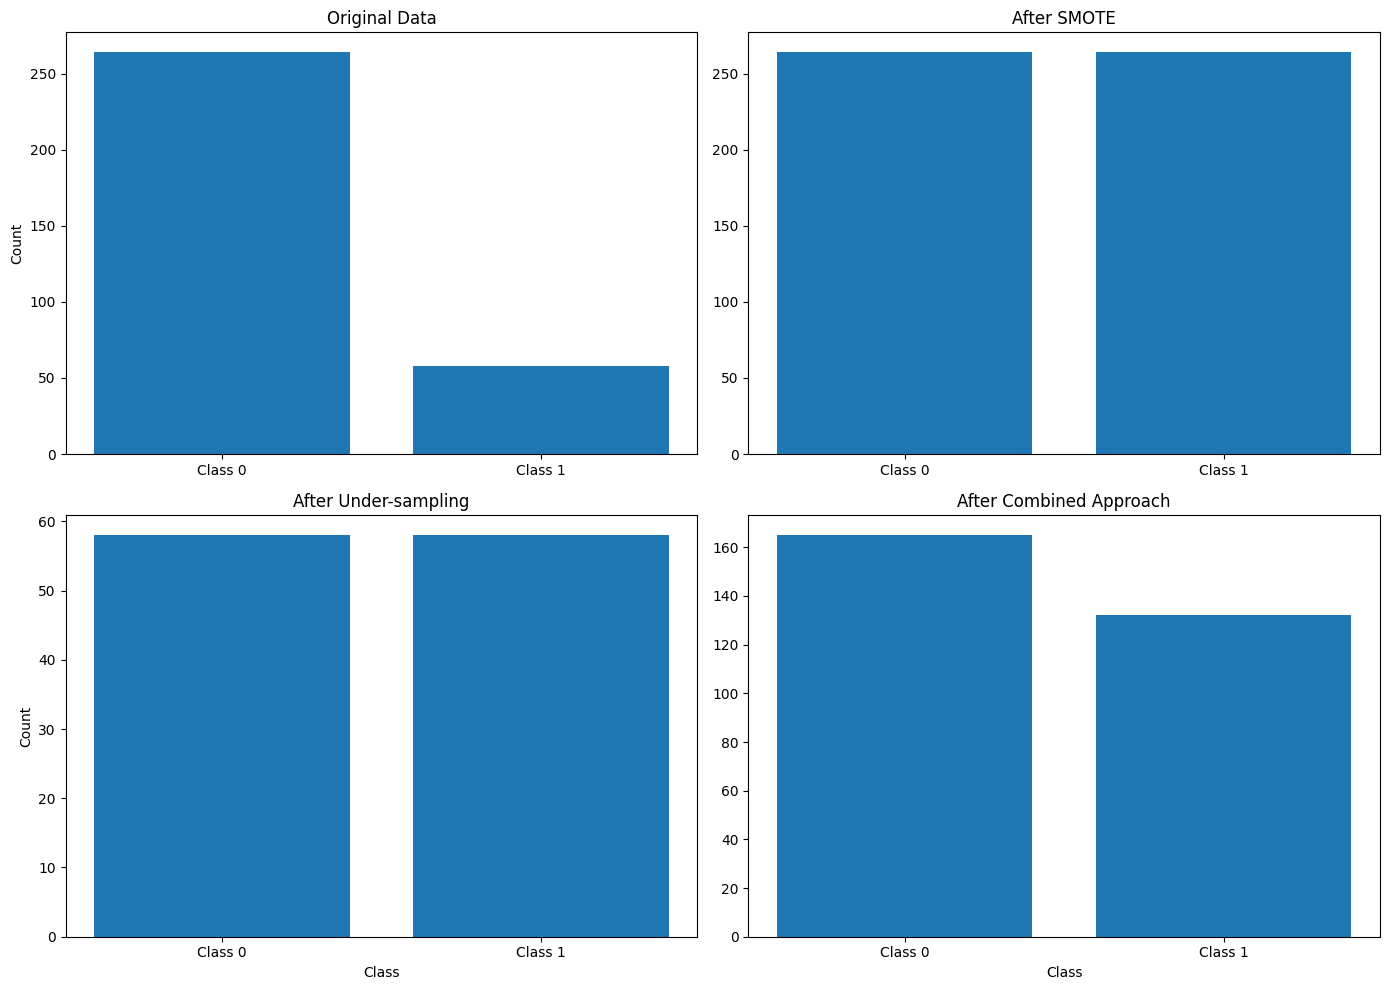


Training MLP with original sampling...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 673ms/step - accuracy: 0.5447 - loss: 1.9636 - val_accuracy: 0.5385 - val_loss: 1.3107
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6550 - loss: 1.3435 - val_accuracy: 0.5692 - val_loss: 1.2715
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7187 - loss: 1.1003 - val_accuracy: 0.5846 - val_loss: 1.2569
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6758 - loss: 1.1764 - val_accuracy: 0.6000 - val_loss: 1.2524
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7228 - loss: 1.0346 - val_accuracy: 0.6308 - val_loss: 1.2616
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7363 - loss: 0.9847 - val_accuracy: 0.6462 - val_loss: 1.2655
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8126 - loss: 0.9051 - val_accuracy: 0.6615 - val_loss: 1.2793
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7813 - loss: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 845ms/step - accuracy: 0.6205 - loss: 1.3114 - val_accuracy: 0.0000e+00 - val_loss: 1.3183
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8177 - loss: 0.9264 - val_accuracy: 0.6415 - val_loss: 1.1801
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8372 - loss: 0.8606 - val_accuracy: 1.0000 - val_loss: 0.9738
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8724 - loss: 0.7927 - val_accuracy: 1.0000 - val_loss: 0.8346
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8882 - loss: 0.7734 - val_accuracy: 1.0000 - val_loss: 0.7574
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9092 - loss: 0.7236 - val_accuracy: 1.0000 - val_loss: 0.7104
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9202 - loss: 0.6785 - val_accuracy: 1.0000 - val_loss: 0.6622
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9402 - loss: 0.6533 - val_accuracy: 1.0000 - val_loss: 0.606

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.5843 - loss: 1.6061 - val_accuracy: 0.8308 - val_loss: 1.1092
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.5234 - loss: 1.4895 - val_accuracy: 0.8462 - val_loss: 1.0787
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6663 - loss: 1.2494 - val_accuracy: 0.8615 - val_loss: 1.0475
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.6223 - loss: 1.2768 - val_accuracy: 0.8615 - val_loss: 1.0194
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6749 - loss: 1.1837 - val_accuracy: 0.8615 - val_loss: 0.9916
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.6201 - loss: 1.2219 - val_accuracy: 0.8615 - val_loss: 0.9648
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.6686 - loss: 1.1497 - val_accuracy: 0.8615 - val_loss: 0.9392
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6587 - loss: 1.1248 - val_accuracy: 0.8615 - val_loss: 0.91

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Results with original sampling:
Accuracy: 0.7482
F1 Score: 0.6404
ROC AUC: 0.6874
PR AUC: 0.4110

Training RandomForest with smote sampling...
Results with smote sampling:
Accuracy: 0.7338
F1 Score: 0.6453
ROC AUC: 0.6666
PR AUC: 0.3615

Training RandomForest with under sampling...
Results with under sampling:
Accuracy: 0.4820
F1 Score: 0.4966
ROC AUC: 0.6850
PR AUC: 0.4177

Training RandomForest with combined sampling...
Results with combined sampling:
Accuracy: 0.7482
F1 Score: 0.7118
ROC AUC: 0.6728
PR AUC: 0.4033

Final Comparison of All Models with Different Sampling Techniques:
           Model  Sampling Accuracy Precision  Recall F1 Score ROC AUC  PR AUC
0            MLP  original   0.5755    0.6489  0.5755   0.6007  0.5580  0.3702
1            MLP     smote   0.7410    0.6747  0.7410   0.6700  0.5940  0.3375
2            MLP     under   0.4532    0.6615  0.4532   0.4740  0.5714  0.3850
3            MLP  combined   0.7050    0.6444  0.7050   0.6624  0.5698  0.3205
4            C

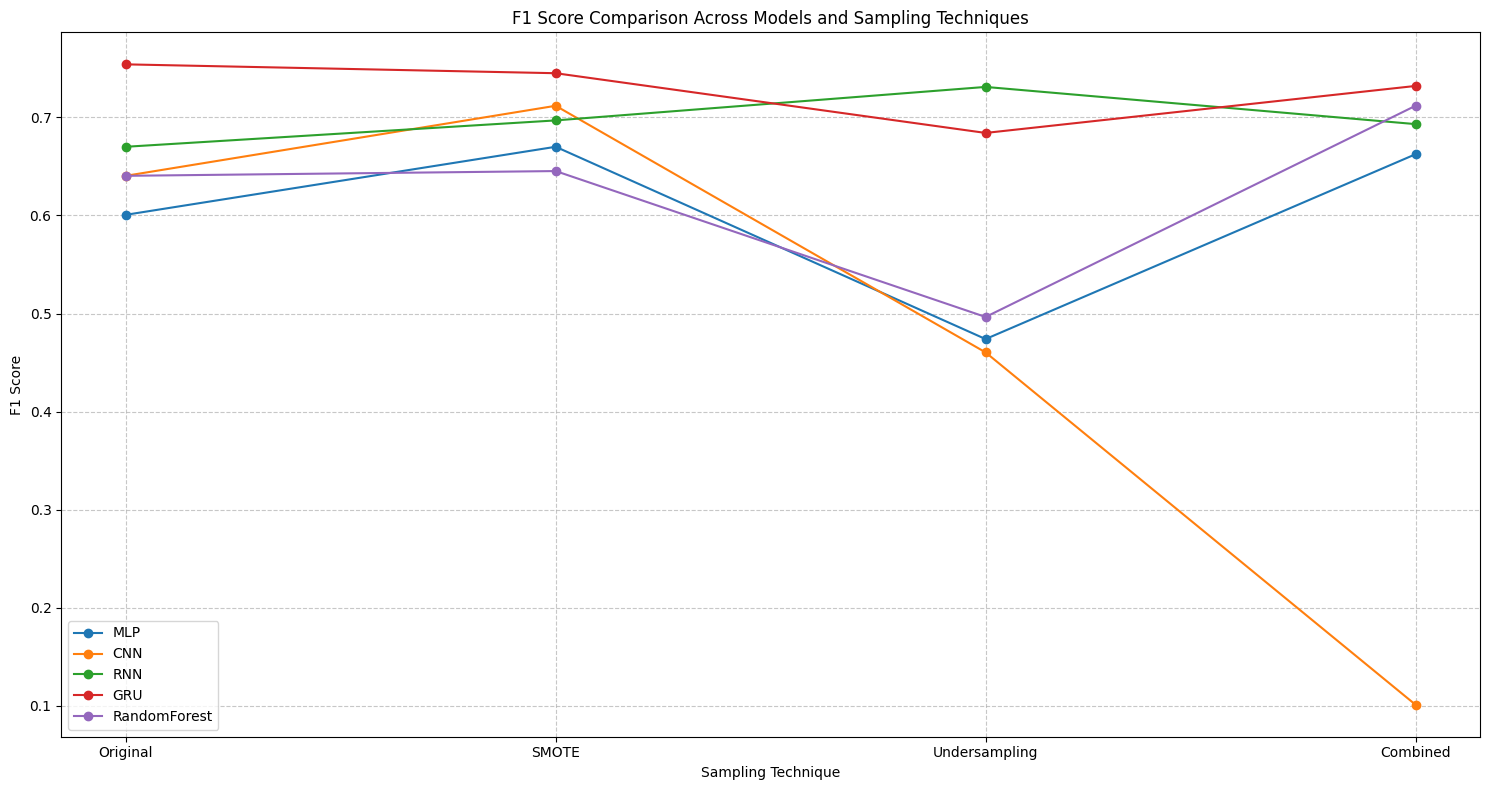

In [3]:
# Install and import imbalanced-learn
try:
    import imblearn
except ImportError:
    !pip install -q imbalanced-learn
    import imblearn

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Function to apply different resampling techniques
def apply_resampling(X, y, technique='smote', random_state=42):
    """Apply resampling techniques to address class imbalance."""
    print(f"Original class distribution: {Counter(y)}")

    if technique == 'smote':
        # Apply SMOTE to oversample the minority class
        smote = SMOTE(random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X, y)

    elif technique == 'under':
        # Apply Random Under-sampling to undersample the majority class
        under = RandomUnderSampler(random_state=random_state)
        X_resampled, y_resampled = under.fit_resample(X, y)

    elif technique == 'combined':
        # Apply both SMOTE and Random Under-sampling
        over = SMOTE(sampling_strategy=0.5, random_state=random_state)  # Increase minority to 50% of majority
        under = RandomUnderSampler(sampling_strategy=0.8, random_state=random_state)  # Reduce majority to 80% of original

        pipeline = Pipeline([
            ('smote', over),
            ('under', under)
        ])

        X_resampled, y_resampled = pipeline.fit_resample(X, y)

    else:
        raise ValueError(f"Unknown resampling technique: {technique}")

    print(f"Resampled class distribution: {Counter(y_resampled)}")

    return X_resampled, y_resampled

# Apply resampling techniques to the training data
print("\nApplying resampling techniques...")

# Apply SMOTE
X_train_smote, y_train_smote_encoded = apply_resampling(
    X_train_scaled, y_train_encoded, technique='smote')

# Apply under-sampling
X_train_under, y_train_under_encoded = apply_resampling(
    X_train_scaled, y_train_encoded, technique='under')

# Apply combined approach
X_train_combined, y_train_combined_encoded = apply_resampling(
    X_train_scaled, y_train_encoded, technique='combined')

# Convert back to categorical for training
y_train_smote_categorical = to_categorical(y_train_smote_encoded)
y_train_under_categorical = to_categorical(y_train_under_encoded)
y_train_combined_categorical = to_categorical(y_train_combined_encoded)

# Reshape for CNN, RNN and GRU (samples, timesteps, features)
X_train_smote_reshaped = X_train_smote.reshape(X_train_smote.shape[0], X_train_smote.shape[1], 1)
X_train_under_reshaped = X_train_under.reshape(X_train_under.shape[0], X_train_under.shape[1], 1)
X_train_combined_reshaped = X_train_combined.reshape(X_train_combined.shape[0], X_train_combined.shape[1], 1)

# Visualize the class distributions
labels = [f"Class {label}" for label in label_encoder.classes_]
original_counts = [np.sum(y_train_encoded == i) for i in range(len(labels))]
smote_counts = [np.sum(y_train_smote_encoded == i) for i in range(len(labels))]
under_counts = [np.sum(y_train_under_encoded == i) for i in range(len(labels))]
combined_counts = [np.sum(y_train_combined_encoded == i) for i in range(len(labels))]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original data
axes[0, 0].bar(labels, original_counts)
axes[0, 0].set_title('Original Data')
axes[0, 0].set_ylabel('Count')

# SMOTE
axes[0, 1].bar(labels, smote_counts)
axes[0, 1].set_title('After SMOTE')

# Under-sampling
axes[1, 0].bar(labels, under_counts)
axes[1, 0].set_title('After Under-sampling')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xlabel('Class')

# Combined
axes[1, 1].bar(labels, combined_counts)
axes[1, 1].set_title('After Combined Approach')
axes[1, 1].set_xlabel('Class')

plt.tight_layout()
plt.savefig("figures/resampling_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# Store resampled data for each model
resampled_data = {
    'MLP': {
        'original': (X_train_scaled, y_train_categorical),
        'smote': (X_train_smote, y_train_smote_categorical),
        'under': (X_train_under, y_train_under_categorical),
        'combined': (X_train_combined, y_train_combined_categorical)
    },
    'CNN': {
        'original': (X_train_reshaped, y_train_categorical),
        'smote': (X_train_smote_reshaped, y_train_smote_categorical),
        'under': (X_train_under_reshaped, y_train_under_categorical),
        'combined': (X_train_combined_reshaped, y_train_combined_categorical)
    },
    'RNN': {
        'original': (X_train_reshaped, y_train_categorical),
        'smote': (X_train_smote_reshaped, y_train_smote_categorical),
        'under': (X_train_under_reshaped, y_train_under_categorical),
        'combined': (X_train_combined_reshaped, y_train_combined_categorical)
    },
    'GRU': {
        'original': (X_train_reshaped, y_train_categorical),
        'smote': (X_train_smote_reshaped, y_train_smote_categorical),
        'under': (X_train_under_reshaped, y_train_under_categorical),
        'combined': (X_train_combined_reshaped, y_train_combined_categorical)
    }
}

# Dictionary to store results for resampling techniques
resampling_results = {}

# Test all neural network models with different sampling techniques
for model_name in ['MLP', 'CNN', 'RNN', 'GRU']:
    resampling_results[model_name] = {}

    for sampling_technique in ['original', 'smote', 'under', 'combined']:
        print(f"\nTraining {model_name} with {sampling_technique} sampling...")

        X_train_sampled, y_train_sampled = resampled_data[model_name][sampling_technique]

        # Set random seed
        np.random.seed(SEED + 100)
        tf.random.set_seed(SEED + 100)
        random.seed(SEED + 100)

        # Create model
        model_creator = model_creators[model_name]
        input_shape = X_train_sampled.shape[1:]
        model = model_creator(input_shape)

        # Define callbacks
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=EARLY_STOPPING_PATIENCE,
            restore_best_weights=True,
            verbose=0
        )

        # We don't need class weights if we've resampled the data (except for original)
        use_class_weights = class_weights if sampling_technique == 'original' else None

        # Train model
        history = model.fit(
            X_train_sampled, y_train_sampled,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            class_weight=use_class_weights,
            callbacks=[early_stopping],
            verbose=1
        )

        # Evaluate on the test set
        X_test_model = model_data[model_name][2]  # Get the appropriate test data format
        y_pred_proba = model.predict(X_test_model, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_true = np.argmax(y_test_categorical, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # For the positive class (major event)
        positive_class = 1
        y_pred_proba_pos = y_pred_proba[:, positive_class]

        # ROC AUC and PR AUC
        try:
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba_pos, pos_label=positive_class)
            roc_auc = auc(fpr, tpr)
            pr_auc = average_precision_score(y_true, y_pred_proba_pos, pos_label=positive_class)
        except:
            roc_auc, pr_auc = 0, 0

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Save results
        resampling_results[model_name][sampling_technique] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'confusion_matrix': cm
        }

        print(f"Results with {sampling_technique} sampling:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"PR AUC: {pr_auc:.4f}")

# Test Random Forest with different sampling techniques
resampling_results['RandomForest'] = {}
for sampling_technique in ['original', 'smote', 'under', 'combined']:
    print(f"\nTraining RandomForest with {sampling_technique} sampling...")

    if sampling_technique == 'original':
        X_train_sampled, y_train_sampled = X_train_scaled, y_train_encoded
    elif sampling_technique == 'smote':
        X_train_sampled, y_train_sampled = X_train_smote, y_train_smote_encoded
    elif sampling_technique == 'under':
        X_train_sampled, y_train_sampled = X_train_under, y_train_under_encoded
    elif sampling_technique == 'combined':
        X_train_sampled, y_train_sampled = X_train_combined, y_train_combined_encoded

    # Set random seed
    np.random.seed(SEED + 100)
    random.seed(SEED + 100)

    # Create and train model
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=True,
        # No need for class_weight with resampled data
        class_weight='balanced' if sampling_technique == 'original' else None,
        random_state=SEED + 100,
        n_jobs=-1
    )

    model.fit(X_train_sampled, y_train_sampled)

    # Evaluate on the test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_test_encoded)
    precision = precision_score(y_test_encoded, y_pred, average='weighted')
    recall = recall_score(y_test_encoded, y_pred, average='weighted')
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')

    # For the positive class (major event)
    positive_class = 1
    y_pred_proba_pos = y_pred_proba[:, positive_class]

    # ROC AUC and PR AUC
    try:
        fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba_pos, pos_label=positive_class)
        roc_auc = auc(fpr, tpr)
        pr_auc = average_precision_score(y_test_encoded, y_pred_proba_pos, pos_label=positive_class)
    except:
        roc_auc, pr_auc = 0, 0

    # Confusion matrix
    cm = confusion_matrix(y_test_encoded, y_pred)

    # Save results
    resampling_results['RandomForest'][sampling_technique] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm
    }

    print(f"Results with {sampling_technique} sampling:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

# Create a comprehensive comparison DataFrame
rows = []
for model_name in resampling_results.keys():
    for technique in resampling_results[model_name].keys():
        result = resampling_results[model_name][technique]
        rows.append({
            'Model': model_name,
            'Sampling': technique,
            'Accuracy': f"{result['accuracy']:.4f}",
            'Precision': f"{result['precision']:.4f}",
            'Recall': f"{result['recall']:.4f}",
            'F1 Score': f"{result['f1_score']:.4f}",
            'ROC AUC': f"{result['roc_auc']:.4f}",
            'PR AUC': f"{result['pr_auc']:.4f}"
        })

final_comparison = pd.DataFrame(rows)
print("\nFinal Comparison of All Models with Different Sampling Techniques:")
print(final_comparison)

# Visualize the F1 scores across models and sampling techniques
plt.figure(figsize=(15, 8))
for model_name in resampling_results.keys():
    f1_scores = [resampling_results[model_name][technique]['f1_score']
                for technique in ['original', 'smote', 'under', 'combined']]
    plt.plot(['Original', 'SMOTE', 'Undersampling', 'Combined'], f1_scores,
             marker='o', label=model_name)

plt.title('F1 Score Comparison Across Models and Sampling Techniques')
plt.xlabel('Sampling Technique')
plt.ylabel('F1 Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig("figures/f1_score_comparison_sampling.png", dpi=300, bbox_inches="tight")
plt.show()